# 1. Introduction
xxxx

In [92]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import nltk
import pytz

from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


sns.set()
random_state = 1

# 2. Data Preprocessing
We will be using two datasets to aid in our stock prediction.
1. Apple Stock Prices (aapl_stock_raw.csv)
2. Twitter Tweets (tweet.csv) *

* The original Tweets dataset is too large to be pushed onto GitHub. 

## 2a. Obtain Stock Data
The dataset we will be using for this problem will consist of the historical daily stock prices of AAPL from 2015-01-01 to 2019-12-31. The description of the data features are as follows:
- date = Date of trading day
- high = Maximum traded price of AAPL stock on that day
- low = Minimum traded price of AAPL stock on that day
- open = The first traded price of AAPL stock on that day
- close = The last traded price of AAPL stock on that day
- adjclose = Adjusted closing price of the day, after accounting for all applicable splits and dividend distributions
- volume = Number of shares of AAPL stock traded on that day
- ticker = AAPL stock symbol

In [4]:
start_date = '2015-01-01'
end_date = '2019-12-31'

# Import dataset
df = pd.read_csv("aapl_stock_raw.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# df.drop(columns=["adjclose", "volume", "ticker"], inplace=True)
df.drop(columns=["ticker"], inplace=True)

# Remove entries outside daterange
df = df[start_date:end_date]

df['change'] = df['close'] - df['open']


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()
df

open       high        low      close   adjclose     volume  \
date                                                                           
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.565697  212818400   
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.873650  257142000   
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.875887  263188400   
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.210684  160423600   
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.140913  237458000   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517097   48478800   
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   93121200   
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869415  146266000   
2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054  144114400   
2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936  100805600   

              change  
date                  
2015-01-02 -0.514999  
2015-01-05 -0.510000  
2015-01-06 -0.070000  
2015-01-07  0.137501  
2015-01-08  0.664999  
...              ...  
2019-12-24 -0.105003  
2019-12-26  1.272499  
2019-12-27 -0.330002  
2019-12-30  0.514999  
2019-12-31  0.930000  

[1258 rows x 7 columns]

## 2b. Tweets data 

Tweets.csv is downloaded from [Kaggle](https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020?resource=download) and loaded into a Pandas dataframe.

As the dataset contains tweets about all the top NASDAQ companies, we remove all the other companies and filter out tweets that mention Apple in their content. 

Next, we clean up the dataset. 
- Convert date to GMT format
- Remove redundant columns
- Remove User Tags and website links (starting with '@' or 'http') and replace with generic terms

In [5]:
# Import dataset
tweets = pd.read_csv(f"Tweet.csv")

# Tweet dataset shows the tweets that mentions the top NASDAQ companies. We remove all the other companies and filter out only tweets that mention apple
tweets = tweets[tweets['body'].str.contains('Apple|AAPL|APPLE|apple|aapl')]

# Convert date form UNIX time to GMT
tweets.rename(columns={"post_date": "date"}, inplace=True)
# tweets['date'] = tweets['date'].apply(lambda x: dt.datetime.fromtimestamp(x, pytz.timezone('Etc/GMT+3')).astimezone(pytz.timezone('Etc/GMT')))
tweets['date'] = pd.to_datetime(tweets['date'], unit='s')
tweets['date'] = tweets['date'].dt.date
tweets = tweets.sort_values('date', ascending=True)

# Remove redundant columns
tweets.drop(columns=["tweet_id", "writer", "comment_num", "retweet_num", "like_num"], inplace=True)

#Replacing user tags and website links to generic terms
# Define a function to clean the text
def clean_text(text):
    words = text.split()
    for i in range(len(words)):
        if words[i].startswith('@'):
            words[i] = '@user'
        elif words[i].startswith('http'):
            words[i] = 'http'
    return ' '.join(words)

# Apply the clean_text function to the 'text' column
tweets['body'] = tweets['body'].apply(clean_text)

tweets

date                                               body
0        2015-01-01  lx21 made $10,008 on $AAPL -Check it out! http...
442      2015-01-01  Apple faces lawsuit over massive storage space...
439      2015-01-01  Today's apps gone free: Decide Now, OftenType,...
437      2015-01-01  Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...
436      2015-01-01  Availability & price are a huge problem plagui...
...             ...                                                ...
3716617  2019-12-31  Thinking about buying stock in $AAPL, $BBY, $C...
3716619  2019-12-31                                       $AAPL Unreal
3716621  2019-12-31  $AAPL march to more nath. 5G coming and everyo...
3716625  2019-12-31  If it is true that everyone already owns Apple...
3717963  2019-12-31  $AAPL #patent 10,522,475 Vertical interconnect...

[1496925 rows x 2 columns]

### Creating Categorical Column (for sentiment analysis)

We will add a column 'Label'. A value of 1 means that closing stock price went up from the previous close and 0 means closing stock price went down from previous close

In [6]:
# Shift the 'Close' column by 1 day to get the previous day's prices
df['prev close'] = df['close'].shift(1)

# Compare 'close' with 'Prev Close' to get the labels
df['label'] = (df['close'] > df['prev close']).astype(int)

#AAPL close price before 02/01/2015 is 27.59
df.loc[0, 'label'] = 1
df.head()

open       high        low      close   adjclose  \
date                                                                         
2015-01-02 00:00:00  27.847500  27.860001  26.837500  27.332500  24.565697   
2015-01-05 00:00:00  27.072500  27.162500  26.352501  26.562500  23.873650   
2015-01-06 00:00:00  26.635000  26.857500  26.157499  26.565001  23.875887   
2015-01-07 00:00:00  26.799999  27.049999  26.674999  26.937500  24.210684   
2015-01-08 00:00:00  27.307501  28.037500  27.174999  27.972500  25.140913   

                          volume    change  prev close  label  
date                                                           
2015-01-02 00:00:00  212818400.0 -0.514999         NaN    0.0  
2015-01-05 00:00:00  257142000.0 -0.510000   27.332500    0.0  
2015-01-06 00:00:00  263188400.0 -0.070000   26.562500    1.0  
2015-01-07 00:00:00  160423600.0  0.137501   26.565001    1.0  
2015-01-08 00:00:00  237458000.0  0.664999   26.937500    1.0

## 2c. Exploratory Data Analysis
Analyse dataset features

In [7]:
df.describe()

open         high          low        close     adjclose  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean     38.599344    38.939050    38.268752    38.619141    36.547029   
std      11.002370    11.103250    10.925538    11.029897    11.259383   
min      22.500000    22.917500    22.367500    22.584999    20.883032   
25%      28.950001    29.130624    28.627500    28.876250    26.493847   
50%      37.593750    38.012501    37.293751    37.638750    35.679941   
75%      46.500627    46.845624    46.167500    46.500626    44.616409   
max      72.779999    73.492500    72.379997    73.412498    71.810936   

             volume       change   prev close        label  
count  1.258000e+03  1258.000000  1257.000000  1259.000000  
mean   1.435996e+08     0.019797    38.591462     0.529786  
std    7.153802e+07     0.464672    10.990491     0.499310  
min    4.544800e+07    -2.275002    22.584999     0.000000  
25%    9.512290e+07    -0.209376    28.875000     0.000000  
50%    1.263050e+08     0.030001    37.637501     1.000000  
75%    1.714582e+08     0.261876    46.465000     1.000000  
max    6.488252e+08     2.217499    72.879997     1.000000

## 3. Sentimental Analysis using VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is particularly good for analysing sentiment of social media texts as it takes into account linguistic features within a social media text. VADER provides 4 normalised sentiment scores: Negative, Neutral, Positive and Compound. The positive, negative, and neutral scores (ranging from 0 to 1) represent the proportion of the text that is positive, negative, or neutral, respectively. The compound score (ranging from -1 to 1) provides an indication as overall indication of the sentiment of the text.

Given the social nature of tweets, we will be using the VADER model as it is very appropriate.


In [8]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The dataset is very massive with over 1 million rows. Running the model will take a few days to complete which is not very efficient. We will concatenate tweets of the same day together. 

To show the concatenating tweets will not affect the conclusion we can derive from the score, let us take a look at the following examples. When we concatenate 2 strings with opposing sentiment, the negative and positive values are scaled closer to 0. Concatenating 2 strings with the same sentiment will result in an unchanged sentiment value. Furthermore, given that these tweets are related to AAPL stock price, concatenating tweets will not result in too much loss in information or context

In [9]:
sia.polarity_scores("I am happy")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [10]:
sia.polarity_scores("I am sad")

{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [11]:
#Concatenating 2 strings with different sentiment 
sia.polarity_scores("I am happy I am sad")

{'neg': 0.352, 'neu': 0.227, 'pos': 0.42, 'compound': 0.1531}

In [12]:
#Concatenating 2 strings with same sentiment
sia.polarity_scores("I am happy I am happy")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.8126}

In [13]:
#Grouping tweets of the same day together
groupedtweet = tweets.groupby('date')['body'].apply(' '.join).reset_index()
groupedtweet

date                                               body
0     2015-01-01  lx21 made $10,008 on $AAPL -Check it out! http...
1     2015-01-02  Stock_Tracker: $AAPL Recent Headlines 5 New Ye...
2     2015-01-03  Free 5€ in account balance for first 100.000 m...
3     2015-01-04  Jake13: $AAPL Opinion Today Click here to find...
4     2015-01-05  Get $25 when you sign up http #Payoneer w/ my ...
...          ...                                                ...
1821  2019-12-27  $AAPL is starting to see Puts coming in. The 1...
1822  2019-12-28  $MTCH $DLTR $QCOM $INTC $AAPL $MSFT $SBUX $AMA...
1823  2019-12-29  Chart Patterns to Watch This Week 12-29-2019 h...
1824  2019-12-30  BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL...
1825  2019-12-31  This has not really been a particularly good y...

[1826 rows x 2 columns]

In [14]:
#Retrieving polarity scores
res = {}

for i,row in tqdm(groupedtweet.iterrows(), total=len(groupedtweet)):
    text = row['body']
    res[i] = sia.polarity_scores(text)

100%|██████████| 1826/1826 [21:48<00:00,  1.39it/s] 


In [15]:
# Adding polarity scores to dataframe
result = pd.DataFrame(res).T
tweet_sentiments = pd.merge(groupedtweet, result, left_index=True, right_index=True)
tweet_sentiments.set_index('date', inplace=True)

tweet_sentiments.index = pd.to_datetime(tweet_sentiments.index)
tweet_sentiments

body    neg    neu  \
date                                                                          
2015-01-01  lx21 made $10,008 on $AAPL -Check it out! http...  0.034  0.848   
2015-01-02  Stock_Tracker: $AAPL Recent Headlines 5 New Ye...  0.052  0.837   
2015-01-03  Free 5€ in account balance for first 100.000 m...  0.025  0.821   
2015-01-04  Jake13: $AAPL Opinion Today Click here to find...  0.030  0.828   
2015-01-05  Get $25 when you sign up http #Payoneer w/ my ...  0.046  0.824   
...                                                       ...    ...    ...   
2019-12-27  $AAPL is starting to see Puts coming in. The 1...  0.042  0.840   
2019-12-28  $MTCH $DLTR $QCOM $INTC $AAPL $MSFT $SBUX $AMA...  0.033  0.853   
2019-12-29  Chart Patterns to Watch This Week 12-29-2019 h...  0.039  0.844   
2019-12-30  BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL...  0.041  0.821   
2019-12-31  This has not really been a particularly good y...  0.041  0.840   

              pos  compound  
date                         
2015-01-01  0.119    0.9999  
2015-01-02  0.111    1.0000  
2015-01-03  0.154    1.0000  
2015-01-04  0.142    1.0000  
2015-01-05  0.129    1.0000  
...           ...       ...  
2019-12-27  0.119    1.0000  
2019-12-28  0.114    0.9999  
2019-12-29  0.116    0.9999  
2019-12-30  0.138    1.0000  
2019-12-31  0.118    1.0000  

[1826 rows x 5 columns]

## Merging stockprice and tweet dataframe

In the process of merging, we will drop the tweets that were tweeted on Saturday, Sunday and public holidays as the stock market is not open on those days.

In [16]:
sentimentAndStockPrice = pd.merge(tweet_sentiments, df, left_index=True, right_index=True)
sentimentAndStockPrice

body    neg    neu  \
date                                                                          
2015-01-02  Stock_Tracker: $AAPL Recent Headlines 5 New Ye...  0.052  0.837   
2015-01-05  Get $25 when you sign up http #Payoneer w/ my ...  0.046  0.824   
2015-01-06  $AAPL: 3 open, suited signals indicate continu...  0.049  0.814   
2015-01-07  $AAPL - strategy MACD and RSI alert - LOL: How...  0.044  0.834   
2015-01-08  $AAPL stock content, charts, analysis, & more ...  0.034  0.830   
...                                                       ...    ...    ...   
2019-12-24  How I Modded the Silicone Tips of AirPods Pro ...  0.040  0.835   
2019-12-26  $AAPL 60 min update $KWBT Visible Whale Count ...  0.041  0.835   
2019-12-27  $AAPL is starting to see Puts coming in. The 1...  0.042  0.840   
2019-12-30  BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL...  0.041  0.821   
2019-12-31  This has not really been a particularly good y...  0.041  0.840   

              pos  compound       open       high        low      close  \
date                                                                      
2015-01-02  0.111       1.0  27.847500  27.860001  26.837500  27.332500   
2015-01-05  0.129       1.0  27.072500  27.162500  26.352501  26.562500   
2015-01-06  0.137       1.0  26.635000  26.857500  26.157499  26.565001   
2015-01-07  0.123       1.0  26.799999  27.049999  26.674999  26.937500   
2015-01-08  0.136       1.0  27.307501  28.037500  27.174999  27.972500   
...           ...       ...        ...        ...        ...        ...   
2019-12-24  0.125       1.0  71.172501  71.222504  70.730003  71.067497   
2019-12-26  0.124       1.0  71.205002  72.495003  71.175003  72.477501   
2019-12-27  0.119       1.0  72.779999  73.492500  72.029999  72.449997   
2019-12-30  0.138       1.0  72.364998  73.172501  71.305000  72.879997   
2019-12-31  0.118       1.0  72.482498  73.419998  72.379997  73.412498   

             adjclose       volume    change  prev close  label  
date                                                             
2015-01-02  24.565697  212818400.0 -0.514999         NaN    0.0  
2015-01-05  23.873650  257142000.0 -0.510000   27.332500    0.0  
2015-01-06  23.875887  263188400.0 -0.070000   26.562500    1.0  
2015-01-07  24.210684  160423600.0  0.137501   26.565001    1.0  
2015-01-08  25.140913  237458000.0  0.664999   26.937500    1.0  
...               ...          ...       ...         ...    ...  
2019-12-24  69.517097   48478800.0 -0.105003   71.000000    1.0  
2019-12-26  70.896324   93121200.0  1.272499   71.067497    1.0  
2019-12-27  70.869415  146266000.0 -0.330002   72.477501    0.0  
2019-12-30  71.290054  144114400.0  0.514999   72.449997    1.0  
2019-12-31  71.810936  100805600.0  0.930000   72.879997    1.0  

[1258 rows x 14 columns]

## 3a. Exploratory Data Analysis On Merged Tweet And Stockprice Dataframe
### 3ai. PLotting Variables Against Stock Price
From the graphs, we can visually observe that when a variable such as negative or postive changes, the direction of the stock price will generally follow suit.

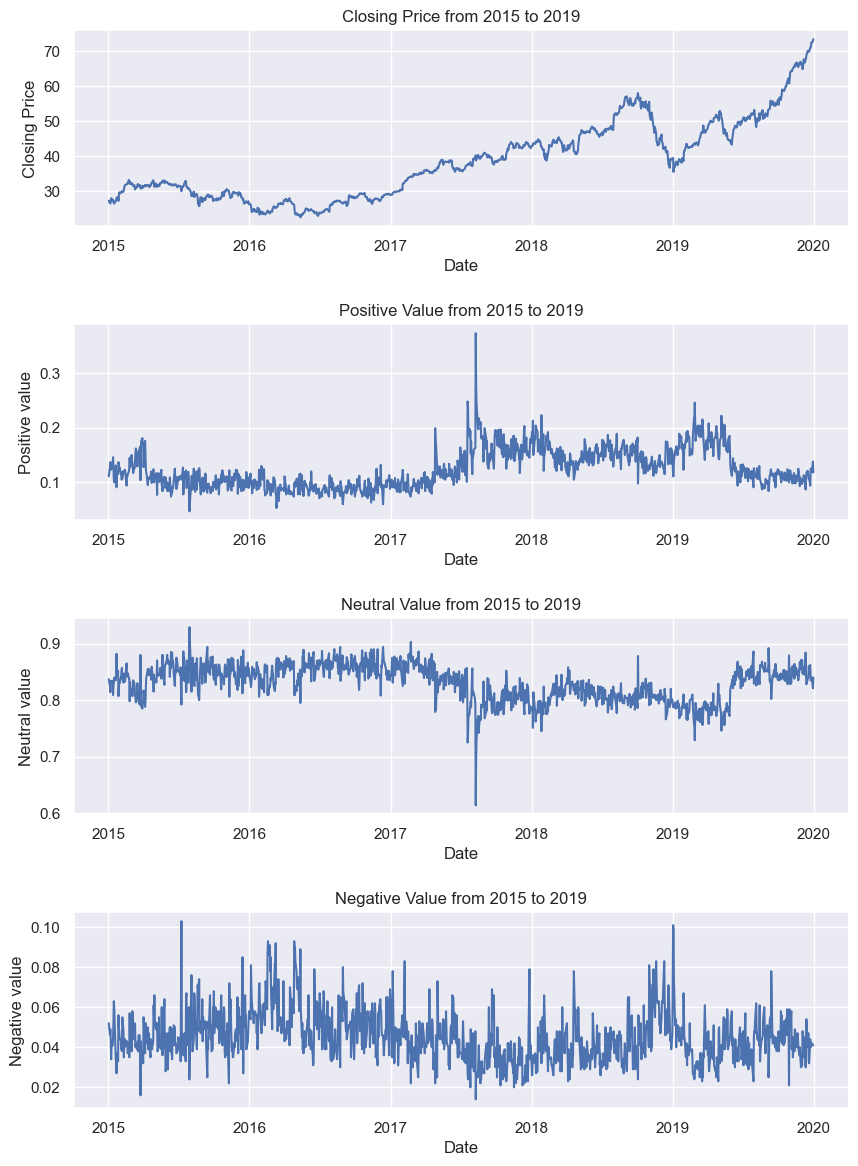

In [17]:
fig, axs = plt.subplots(4, figsize=(10, 14))

# Plot closing prices
axs[0].plot(df.index, df['close'])
axs[0].set_title('Closing Price from 2015 to 2019')
axs[0].set(xlabel='Date', ylabel='Closing Price')

# Plot positive values
axs[1].plot(sentimentAndStockPrice.index, sentimentAndStockPrice['pos'])
axs[1].set(xlabel='Date', ylabel='Positive value')
axs[1].set_title('Positive Value from 2015 to 2019')

# Plot neutral values
axs[2].plot(sentimentAndStockPrice.index, sentimentAndStockPrice['neu'])
axs[2].set(xlabel='Date', ylabel='Neutral value')
axs[2].set_title('Neutral Value from 2015 to 2019')

# Plot negative values
axs[3].plot(sentimentAndStockPrice.index, sentimentAndStockPrice['neg'])
axs[3].set(xlabel='Date', ylabel='Negative value')
axs[3].set_title('Negative Value from 2015 to 2019')

plt.subplots_adjust(hspace=0.5)
plt.show()

### 3aii. Visualising Distribution of Sentiment Values


Text(0, 0.5, 'Frequency')

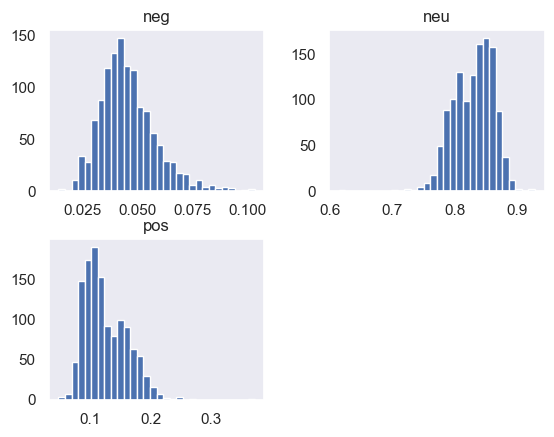

In [18]:
hist = sentimentAndStockPrice.hist(column=['neg', 'neu', 'pos'], bins=30, grid=False)

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

### 3aiii. Observation 1: Positive Skew of Sentiment Values
'neg' and 'pos' variables have a positive skew. We will correct them using log transformation. This is important later on as our model depends on a normal distribution

Text(0, 0.5, 'Frequency')

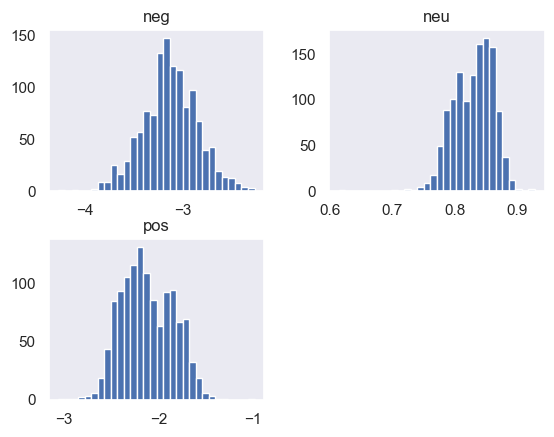

In [19]:
sentimentAndStockPrice['neg'] = np.log(sentimentAndStockPrice['neg'])
sentimentAndStockPrice['pos'] = np.log(sentimentAndStockPrice['pos'])

hist = sentimentAndStockPrice.hist(column=['neg', 'neu', 'pos'], bins=30, grid=False)

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

#### Visualising Correlation Between Sentiment Values and AAPL Daily Close Price

In [20]:
#Printing correlation matrix
corr_matrix = sentimentAndStockPrice[['close','neg', 'neu', 'pos']].corr()[['close']]
corr_matrix

close
close  1.000000
neg   -0.313852
neu   -0.357094
pos    0.478869

### 3aiv. Observation 2: Positive and Negative Have Medium Correlation with Daily Close Price

'neg' has a correlation of -0.323881 and 'pos' has a correlation of 0.441454 against closing price. Since negative and positive have a medium correlation against AAPL daily close price, we can use these 2 variables for our model. 

We will not use neutral values as they do not display any emotions or sentiments from tweet users that can help to predict stock price

## 3b. Methodology
We will use the sentiment variables, namely negative and positive values, to help predict whether or not the stock price will rise or fall. Since our sentiment values range from 0 to 1, it is not possible to predict the stock price as the stock price can reach new highs and these data is not present in our dataset (i.e. if stock price keeps going up, our sentiment variable will never exceed 1). Given this limitation, we can however still use twitter sentiment to predict whether or not AAPL stock price will rise or fall given the sentiment on that day

### 3bi. Creating Train-Test Set
Given that we are handling a time series data, we will not be using any cross validation methods. Train set will be from 2015-2018, Test set will be 2019

In [21]:
# Prepare training set
sentimentAndStockPrice.index = pd.to_datetime(sentimentAndStockPrice.index)
sentiment_train_df = sentimentAndStockPrice['2015-01-01':'2018-12-31']
sentiment_train_df

body       neg  \
date                                                                      
2015-01-02  Stock_Tracker: $AAPL Recent Headlines 5 New Ye... -2.956512   
2015-01-05  Get $25 when you sign up http #Payoneer w/ my ... -3.079114   
2015-01-06  $AAPL: 3 open, suited signals indicate continu... -3.015935   
2015-01-07  $AAPL - strategy MACD and RSI alert - LOL: How... -3.123566   
2015-01-08  $AAPL stock content, charts, analysis, & more ... -3.381395   
...                                                       ...       ...   
2018-12-24  >>>DONALD TRUMP!<<< ---- FANG. ---> How about ... -2.918771   
2018-12-26  Join @user and we'll both get a stock like $AA... -3.146555   
2018-12-27  Afternoon Price Volume Leaders $AMZN $AAPL $MS... -3.079114   
2018-12-28  In Live session we covered $AAPL at http and l... -3.244194   
2018-12-31  Hopefully $AMZN and $AAPL keep going up. The s... -3.079114   

              neu       pos  compound       open       high        low  \
date                                                                     
2015-01-02  0.837 -2.198225       1.0  27.847500  27.860001  26.837500   
2015-01-05  0.824 -2.047943       1.0  27.072500  27.162500  26.352501   
2015-01-06  0.814 -1.987774       1.0  26.635000  26.857500  26.157499   
2015-01-07  0.834 -2.095571       1.0  26.799999  27.049999  26.674999   
2015-01-08  0.830 -1.995100       1.0  27.307501  28.037500  27.174999   
...           ...       ...       ...        ...        ...        ...   
2018-12-24  0.788 -1.845160       1.0  37.037498  37.887501  36.647499   
2018-12-26  0.795 -1.820159       1.0  37.075001  39.307499  36.680000   
2018-12-27  0.820 -2.009915       1.0  38.959999  39.192501  37.517502   
2018-12-28  0.798 -1.820159       1.0  39.375000  39.630001  38.637501   
2018-12-31  0.801 -1.877317       1.0  39.632500  39.840000  39.119999   

                close   adjclose       volume    change  prev close  label  
date                                                                        
2015-01-02  27.332500  24.565697  212818400.0 -0.514999         NaN    0.0  
2015-01-05  26.562500  23.873650  257142000.0 -0.510000   27.332500    0.0  
2015-01-06  26.565001  23.875887  263188400.0 -0.070000   26.562500    1.0  
2015-01-07  26.937500  24.210684  160423600.0  0.137501   26.565001    1.0  
2015-01-08  27.972500  25.140913  237458000.0  0.664999   26.937500    1.0  
...               ...        ...          ...       ...         ...    ...  
2018-12-24  36.707500  35.375175  148676800.0 -0.329998   37.682499    0.0  
2018-12-26  39.292500  37.866348  234330000.0  2.217499   36.707500    1.0  
2018-12-27  39.037498  37.620602  212468400.0  0.077499   39.292500    0.0  
2018-12-28  39.057499  37.639881  169165600.0 -0.317501   39.037498    1.0  
2018-12-31  39.435001  38.003681  140014000.0 -0.197498   39.057499    1.0  

[1006 rows x 14 columns]

In [22]:
# Prepare test set
sentiment_test_df = sentimentAndStockPrice['2019-01-01':'2019-12-31']
sentiment_test_df

body       neg  \
date                                                                      
2019-01-02  $AAPL collapsing LOL Tim Cook’s vision was to ... -2.292635   
2019-01-03  Yeah, $AAPL had been "Holding" that Sales Info... -2.312635   
2019-01-04  Yep. I did a #podcast about why $AAPL stock ta... -2.603690   
2019-01-07  +500 $INDU and $AAPL goes green. Book it. Here... -2.975930   
2019-01-08  that's what FATUOUS @user gov shutdown brings ... -2.918771   
...                                                       ...       ...   
2019-12-24  How I Modded the Silicone Tips of AirPods Pro ... -3.218876   
2019-12-26  $AAPL 60 min update $KWBT Visible Whale Count ... -3.194183   
2019-12-27  $AAPL is starting to see Puts coming in. The 1... -3.170086   
2019-12-30  BOT $AAPL Jan 03 2020 W 287.50 Put @user $AAPL... -3.194183   
2019-12-31  This has not really been a particularly good y... -3.194183   

              neu       pos  compound       open       high        low  \
date                                                                     
2019-01-02  0.788 -2.198225       1.0  38.722500  39.712502  38.557499   
2019-01-03  0.790 -2.198225       1.0  35.994999  36.430000  35.500000   
2019-01-04  0.787 -1.973281       1.0  36.132500  37.137501  35.950001   
2019-01-07  0.791 -1.845160       1.0  37.174999  37.207500  36.474998   
2019-01-08  0.796 -1.897120       1.0  37.389999  37.955002  37.130001   
...           ...       ...       ...        ...        ...        ...   
2019-12-24  0.835 -2.079442       1.0  71.172501  71.222504  70.730003   
2019-12-26  0.835 -2.087474       1.0  71.205002  72.495003  71.175003   
2019-12-27  0.840 -2.128632       1.0  72.779999  73.492500  72.029999   
2019-12-30  0.821 -1.980502       1.0  72.364998  73.172501  71.305000   
2019-12-31  0.840 -2.137071       1.0  72.482498  73.419998  72.379997   

                close   adjclose       volume    change  prev close  label  
date                                                                        
2019-01-02  39.480000  38.047039  148158800.0  0.757500   39.435001    1.0  
2019-01-03  35.547501  34.257275  365248800.0 -0.447498   39.480000    0.0  
2019-01-04  37.064999  35.719692  234428400.0  0.932499   35.547501    1.0  
2019-01-07  36.982498  35.640190  219111200.0 -0.192501   37.064999    0.0  
2019-01-08  37.687500  36.319611  164101200.0  0.297501   36.982498    1.0  
...               ...        ...          ...       ...         ...    ...  
2019-12-24  71.067497  69.517097   48478800.0 -0.105003   71.000000    1.0  
2019-12-26  72.477501  70.896324   93121200.0  1.272499   71.067497    1.0  
2019-12-27  72.449997  70.869415  146266000.0 -0.330002   72.477501    0.0  
2019-12-30  72.879997  71.290054  144114400.0  0.514999   72.449997    1.0  
2019-12-31  73.412498  71.810936  100805600.0  0.930000   72.879997    1.0  

[252 rows x 14 columns]

In [23]:
# Split into Train and Test sets
X_train = np.array(sentiment_train_df[['neg','pos']])
Y_train = sentiment_train_df['label'].values
X_test = np.array(sentiment_test_df[['neg','pos']])
Y_test = sentiment_test_df['label'].values

## 3c. Linear Discriminant Analysis



Linear Discriminant Analysis (LDA) is a supervised machine learning algorithm that is used for classification tasks. LDA helps to find a linear combination of features that can best separate 2 or more classes of data.

In LDA, the input data consists of a set of labeled samples, where each sample has a set of features or attributes. The algorithm seeks to find a projection of the data onto a lower-dimensional space, such that the samples in each class are well-separated from each other and as far apart as possible. This lower-dimensional space is called the discriminant space.

LDA would then be used to find a projection of the data onto a lower-dimensional space, such that the samples in each class are well-separated from each other and as far apart as possible. The resulting projection can be used to classify new samples by assigning them to the class that is closest to their projected value.

In the context of predicting AAPL stock price direction, LDA takes in AAPL stock price as well as the negative and positive sentiment values to help derive whether to buy or sell a stock. This information can be particularly useful for day traders whose objective is to enter and exit a trade within a short period of time.



In [24]:
model = LinearDiscriminantAnalysis().fit(X_train,Y_train)

predictions = model.predict(X_test)
predictions

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1.

In [25]:
Y_test

array([1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0.

In [26]:
#Show the model metrics
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.49      0.37      0.42       106
         1.0       0.61      0.72      0.66       146

    accuracy                           0.57       252
   macro avg       0.55      0.54      0.54       252
weighted avg       0.56      0.57      0.56       252



### 3ci. Linear Discriminant Analysis Results
We have achieved the following with LDA:

- Overall Accuracy of 0.57
- For predicting close price decreasing (class 0.0):
    - Precision of 0.49
    - Recall of 0.37
    - f1-score of 0.42
- For predicting close price increasing (class 1.0):
    - Precision of 0.61
    - Recall of 0.72
    - f1-score of 0.66


We can conclude the following from using LDA:

- Precision: Only 53% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 61% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 27% of the negative samples are correctly categorised as negative. 82% (A high percentage) of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.70) than predicting decrease(0.36) in AAPL close price. Overall, LDA is better used to predict whether AAPL close price goes up than predicting whether it goes down

## 3d. Further Experimentation
Given that LDA is rather inaccurate in predicting the fall in closing price, let us bring in a few more classification models that can help to cover this gap. We will be using the same metrics as above to compare our model effectivness. Namely:
1. Accuracy
2. Precision
3. Recall
4. f1-score


We will compare LDA with 2 other classification models:
1. Logistic Regression
2. Random Forest

## 3e. Logistic Regression

Logistic regression is useful in predicting binary outcomes which can be useful in our case of predicting stock price movement.

Logistic regression relies heavily in linearity between the independent variables and the log-odds of the dependent variable.

Logistic regression can be useful in this scenario as it is a relatively simple and interpretable model that can provide insights into the factors that are driving stock price movements. Additionally, logistic regression can be used to estimate the probability of a particular event occurring, such as the probability of a stock price going up or down, which can be useful for making informed investment decisions.

In [27]:
model2 = LogisticRegression().fit(X_train,Y_train)

# Predict on the test set
LR_pred = model2.predict(X_test)

In [28]:
print(classification_report(Y_test,LR_pred))

              precision    recall  f1-score   support

         0.0       0.49      0.36      0.41       106
         1.0       0.61      0.73      0.66       146

    accuracy                           0.57       252
   macro avg       0.55      0.54      0.54       252
weighted avg       0.56      0.57      0.56       252



### 3ei. Logistic Regression Results
We have achieved the following with Logistic Regression:

- Overall Accuracy of 0.57
- For predicting close price decreasing (class 0.0):
    - Precision of 0.49
    - Recall of 0.36
    - f1-score of 0.41
- For predicting close price increasing (class 1.0):
    - Precision of 0.61
    - Recall of 0.73
    - f1-score of 0.66

We can conclude the following from using Logistic Regression:

- Precision: Only 50% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 58% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 1% of the negative samples are correctly categorised as negative. 99% (A high percentage) of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.73) than predicting decrease(0.02) in AAPL close price.

### 3f. Random Forest Classifier
Random forest classifier is well suited in predicting stock price movement because it can handle complex and non-linear relationship between the independent variable (which in this case is sentiment values) and target variable (movement of stock closing price)

Random forest works by creating multiple decision trees and combining their predictions to generate a final prediction. Each decision tree is trained on a random subset of the data, and each split in the tree is based on a randomly selected subset of the features. This helps to reduce overfitting and improve the model's generalization performance.

Random forest classifier can be used because it can handle numerous features which in this case is positive and negative sentiment values.

In [29]:
model3 = RandomForestClassifier().fit(X_train,Y_train)

# Predict on the test set
RFC_pred = model3.predict(X_test)

print(classification_report(Y_test,RFC_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.51      0.50       106
         1.0       0.64      0.63      0.63       146

    accuracy                           0.58       252
   macro avg       0.57      0.57      0.57       252
weighted avg       0.58      0.58      0.58       252



### 3fi. Random Forest Classifier Results
We have achieved the following with Logistic Regression:

- Overall Accuracy of 0.55
- For predicting close price decreasing (class 0.0):
    - Precision of 0.48
    - Recall of 0.47
    - f1-score of 0.47
- For predicting close price increasing (class 1.0):
    - Precision of 0.61
    - Recall of 0.61
    - f1-score of 0.61

We can conclude the following from using Random Forest Classifier:

- Precision: Only 48% of the data from the test set is actually predicted to be negative are true negative. On the other hand, 61% of the data from the test set predicted to be positive are actually true positive.
- Recall: Only 45% of the negative samples are correctly categorised as negative. 63% of positive samples are correctly categorised as positive.
- F1 Score: f1-score for predicting increase in AAPL close price is higher(0.62) than predicting decrease(0.46) in AAPL close price.

## 3g. Comparing All 3 Models for Sentiment Analysis
A barplot is used to visualise how each model fares

### 3gi. Comparing Class 0 (Predicting Decrease in Closing Price)

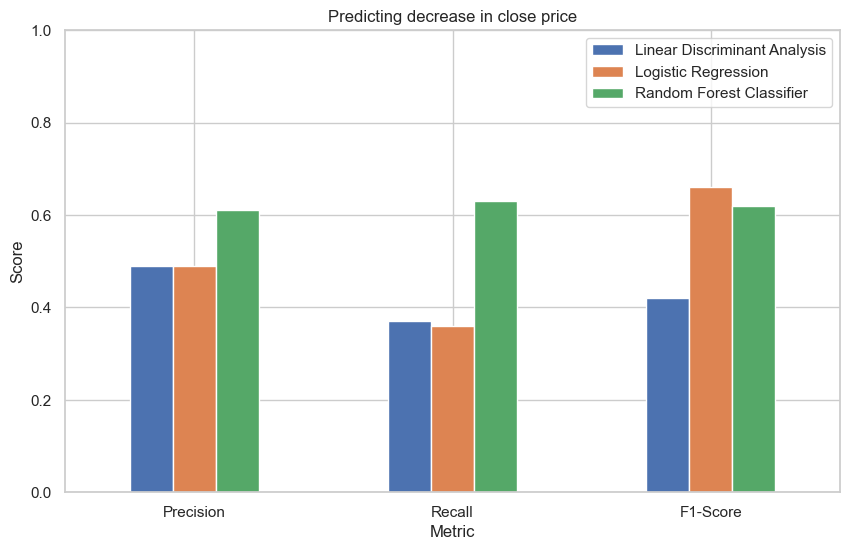

In [30]:
# Define data as a dictionary of models and their classification report
data = {'Linear Discriminant Analysis': [0.49,0.37,0.42],
        'Logistic Regression': [0.49, 0.36, 0.66],
        'Random Forest Classifier': [0.61, 0.63, 0.62]}
# Convert data to a DataFrame
report = pd.DataFrame(data)

# Plot the bar plot
sns.set(style="whitegrid")
ax = report.plot(kind='bar', rot=0, figsize=(10, 6))
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
plt.title('Predicting decrease in close price')
plt.legend(labels=['Linear Discriminant Analysis', 'Logistic Regression', 'Random Forest Classifier'])
plt.show()

### 3gii. Comparing Class 1 (Predicting Increase in Closing Price)

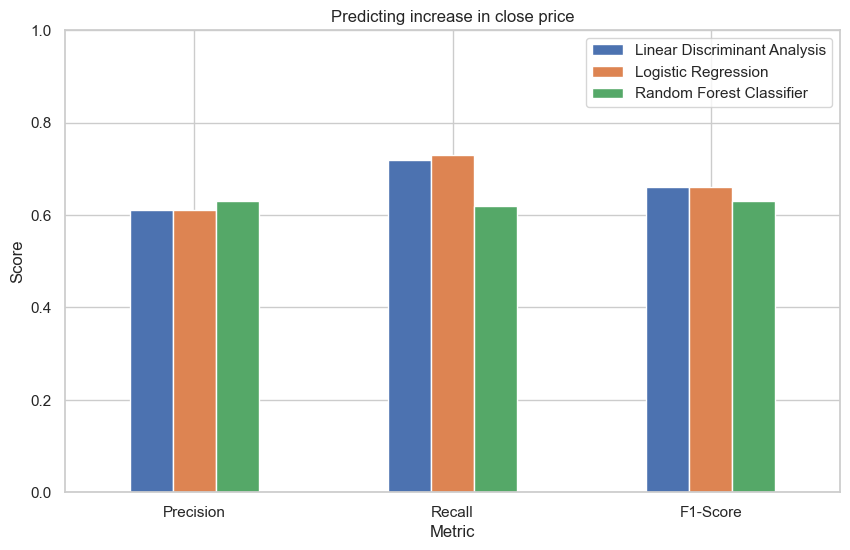

In [31]:
# Define data as a dictionary of models and their classification report
data = {'Linear Discriminant Analysis': [0.61,0.72,0.66],
        'Logistic Regression': [0.61, 0.73, 0.66],
        'Random Forest Classifier': [0.63, 0.62, 0.63]}
# Convert data to a DataFrame
report = pd.DataFrame(data)

# Plot the bar plot
sns.set(style="whitegrid")
ax = report.plot(kind='bar', rot=0, figsize=(10, 6))
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
plt.title('Predicting increase in close price')
plt.legend(labels=['Linear Discriminant Analysis', 'Logistic Regression', 'Random Forest Classifier'])
plt.show()

### Comparing all 3 models, we conclude the following:

Ranking based on overall performance:

1. Random Forest Classifier
2. Linear Discriminant Analysis
3. Logistic Regression Model

Starting off, random forest classifier proved to be a relatively reliable model with a 56% accuracy. All things considered, it is the preferable model to be used for prediction.

Linear Discriminant Analysis came up with a 59% accuracy. However, it is important to note that it fares poorly in predicting a fall in stock close price (f1-score of 0.36)

Lastly, Logistic regression fared the worst as most of its prediction predicted a rise in close price. 

## 3h. Conclusion
We can conclude that there is a medium correlation between twitter sentiments and the AAPL closing price movement. As such, there is a premise to carry out machine learning to use twitter sentiments to predict AAPL closing price movement. In the context of social media sentiment, the models proved to have a high percentage accuracy given the noise and complexity of the data we are handling with. Even though we did as much textual cleaning as possible, it is difficult to perfectly clean our dataset of over 1 million tweets. In addition, given the highly speculative nature of people, what people say on twitter may not effectively translate into a accurate stock close price movement. 

Given the competitive trading space and high stakes nature that involves the use of people's hard earned money, we cannot completely rely on sentiment analysis to make stock price movement predictions. Rather, we can use it hand in hand with other indicators such as economic indicators and stock technical indicators to help come up with an educated prediction 

## 3i. Limitations and Possible Improvements 

- Limitation: Relatively unreliable textual source 
Twitter is not representative of the entire population. The demographics that uses twitter are mainly millenials whereas the people involved in the stock market are of a wide range of age. In addition, tweets can contain sarcasm, which is difficult for current sentiment models to read and predict. 

- Improvement : We can incorporate financial news articles into our sentiment analysis. New articles tend to be less biased and contain less noise.


# 4. Stock Prediction Using Technical Indicators Model
## 4a. Introduction
Stock price movement can be predicted using a variety of technical indicators. As we would like to be able to predict whether or not we should buy or sell a stock at a certain time, we could therefore turn to technical indicators to aid us in deciding whether or not buy or sell a stock. 

For this portion, we will be using data on historical stock prices and 4 main technical indicators, namely the Simple Moving Average, Exponential Moving Average, Moving Average Convergence/Divergence and the Relative Strength Index, to build a machine learning model that can utilise technical indicators to classify buy and sell signals.

With this model, one could estimate the best times to buy or sell a stock, and hence make a more informed decision on whether or not it was a good time to buy AAPL stock, which could potentially translate to increased profits trading AAPL stock.

For this project, we will also consider a potential rise in price as a buy signal, while a potential fall in price will be a sell signal.

### Overview:
- Data Preprocessing
    - In this stage, we will remove any redundant columns which might add unneccessary noise to our dataset. We will also ensure all the data is of appropriate data types and ensure no values are missing. In addition, we will also conduct an analysis of our dataset to observe and determine any possible trends in our dataset, as well as create new columns that could be useful in helping us determining buy and sell signals. These would be helpful in ensuring that our machine learning model can be trained effectively and generate accurate buy and sell signals.
- Methodology and Experiments
    - In this section, we would train, validate and test 4 different machine learning models using the technical indicators data that we have obtained via preprocessing. We would also be manually tuning the hyperparameters of the 4 models to maximize each model's performance, since we should abstain from cross validation on a time series data.
    - We would also measure their effectiveness using a variety of classification metrics such as Accuracy, True Positive Rate, True Negative Rate etc.,  which will allow us to compare the different models we have built and determine the model that is most effective in classifying buy and sell signals.
- Conclusion
    - Lastly, we will summarize our findings in this project and determine any limitations and possible improvements we could make to our model.

In [32]:
# Reset changes to stock data dataframe
start_date = '2015-01-01'
end_date = '2019-12-31'

# Import dataset
df = pd.read_csv("aapl_stock_raw.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# df.drop(columns=["adjclose", "volume", "ticker"], inplace=True)
df.drop(columns=["ticker"], inplace=True)

# Remove entries outside daterange
df = df[start_date:end_date]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1258 non-null   float64
 1   high      1258 non-null   float64
 2   low       1258 non-null   float64
 3   close     1258 non-null   float64
 4   adjclose  1258 non-null   float64
 5   volume    1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


## 4b. Data Preprocessing
### 4bi. Obtain Indicators Data
For this project, we will be focussing on short term (20 days) to medium term (50 days) investing or trading, hence, we must calculate the short and medium term technical indicator data for the Simple Moving Average (SMA), Exponential Moving Average (EMA), Moving Average Convergence/Divergence (MACD) and the Relative Strength Index (RSI):
- SMA = Average close price of AAPL stock in a specified window
- EMA = Weight averaged close price of AAPL stock in a specified window, with more focus on the current price
- MACD = Identifies the momentum of a particular trend, and highlights the relationship between the 12 and 16 day EMAs of AAPL stock price, this is used in tandem with a signal variable, which is the 9 day EMA of MACD
- RSI = Measures the speed and magnitude of AAPL's recent price changes to determines if it is overvalued or undervalued

In [33]:
def getSMA(data, window):
    data[f'sma_{window}'] = data['close'].rolling(window).mean()
    return data

def getEMA(data, window):
    data[f'ema_{window}'] = data['close'].ewm(span=window).mean()
    return data

def getMACD(data):
    data['macd_12'] = data['close'].ewm(span=12).mean()
    data['macd_26'] = data['close'].ewm(span=26).mean()
    data['macd_value'] = data['macd_12'] - data['macd_26']
    data['macd_price_signal'] = data['macd_value'].ewm(span=9).mean()
    data = data.drop(columns=['macd_12', 'macd_26'])
    return data

def getRSI(data, window):
    close_delta = data['close'].diff()
    
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = window - 1, adjust=True, min_periods = window).mean()
    ma_down = down.ewm(com = window - 1, adjust=True, min_periods = window).mean()
        
    data[f'rsi_{window}'] = 100 - (100/(1 + (ma_up / ma_down)))
    return data

Get stock data

In [34]:
pre_start_date = dt.date.fromisoformat(start_date) - dt.timedelta(100)  # Buffer data to ensure that all entries after '2015-01-01' are not null after transformation
post_end_date = dt.date.fromisoformat(end_date) + dt.timedelta(1)  # The date range we want must be inclusive on our end_date
stock_df = pd.read_csv('aapl_stock_raw.csv', index_col=0)
stock_df.drop(columns=['ticker'], inplace=True)
stock_df.dropna(inplace=True)

short_window = 20
medium_window = 50

# SMA for both short and medium windows
stock_df = getSMA(stock_df, short_window)
stock_df = getSMA(stock_df, medium_window)

# EMA for both short and medium windows
stock_df = getEMA(stock_df, short_window)
stock_df = getEMA(stock_df, medium_window)

# MACD
stock_df = getMACD(stock_df)

# RSI for both short and medium windows
stock_df = getRSI(stock_df, short_window)
stock_df = getRSI(stock_df, medium_window)

stock_df.head()

date       open       high        low      close   adjclose  \
0  2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931   
1  2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763817   
2  2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895775   
3  2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540091   
4  2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   

      volume  sma_20  sma_50     ema_20     ema_50  macd_value  \
0  253608800     NaN     NaN  25.660000  25.660000    0.000000   
1  240687200     NaN     NaN  25.543187  25.546525   -0.004992   
2  400368000     NaN     NaN  25.148202  25.172369   -0.036440   
3  249482000     NaN     NaN  25.159547  25.176382   -0.023855   
4  199065200     NaN     NaN  25.127606  25.144177   -0.022881   

   macd_price_signal  rsi_20  rsi_50  
0           0.000000     NaN     NaN  
1          -0.002773     NaN     NaN  
2          -0.016571     NaN     NaN  
3          -0.019039     NaN     NaN  
4          -0.020182     NaN     NaN

### 4bii. Obtain Difference and Signal For Respective Indicators
Since indicators like SMA, EMA and MACD indicate buy and sell signals based on whether the short-term trend is greater than than the medium-term trend, we must create a new column to capture the difference between the respective indicators. We will also create a new column to capture the buy or sell signal if the indicator was used individually. Another benefit to this is so that the model will make classifications based on the difference and the individual signals as opposed to the price of AAPL stock.

No new column will be created for RSI since RSI is mainly used as a filter or confirmation for a signal based off other indicators as opposed to an independent signal indicator.

In [35]:
stock_df['sma_diff'] = stock_df['sma_20'] - stock_df['sma_50']
stock_df['sma_signal'] = stock_df['sma_20'] > stock_df['sma_50']

stock_df['ema_diff'] = stock_df['ema_20'] - stock_df['ema_50']
stock_df['ema_signal'] = stock_df['ema_20'] > stock_df['ema_50']

stock_df['macd_diff'] = stock_df['macd_value'] - stock_df['macd_price_signal']
stock_df['macd_signal'] = stock_df['macd_value'] > stock_df['macd_price_signal']

stock_df.head()

date       open       high        low      close   adjclose  \
0  2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931   
1  2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763817   
2  2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895775   
3  2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540091   
4  2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   

      volume  sma_20  sma_50     ema_20  ...  macd_value  macd_price_signal  \
0  253608800     NaN     NaN  25.660000  ...    0.000000           0.000000   
1  240687200     NaN     NaN  25.543187  ...   -0.004992          -0.002773   
2  400368000     NaN     NaN  25.148202  ...   -0.036440          -0.016571   
3  249482000     NaN     NaN  25.159547  ...   -0.023855          -0.019039   
4  199065200     NaN     NaN  25.127606  ...   -0.022881          -0.020182   

   rsi_20  rsi_50  sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  \
0     NaN     NaN       NaN       False  0.000000       False   0.000000   
1     NaN     NaN       NaN       False -0.003337       False  -0.002219   
2     NaN     NaN       NaN       False -0.024168       False  -0.019869   
3     NaN     NaN       NaN       False -0.016835       False  -0.004817   
4     NaN     NaN       NaN       False -0.016571       False  -0.002700   

   macd_signal  
0        False  
1        False  
2        False  
3        False  
4        False  

[5 rows x 21 columns]

### 4biii. Relationship Between AAPL Stock PRice and Respective Indicators
In general, we can observe the following trends for the technical indicators specified above:
- All 4 indicators follow AAPL's price trend, as seen from how the valule of the indicators and AAPL's stock price usually rise or fall at around the same time
- The shorter-term (20 day) SMA, EMA and RSI are more reactive to changes in AAPL's stock price compared to the longer-term (50 day) SMA, EMA and RSI respectively
- EMA is more reactive to changes in AAPL's stock price, which demonstrates its emphasis on more current prices of AAPL's stock

In [36]:
stock = 'AAPL'

def plotCandle(data, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_candlestick(
        x = data['date'],
        low = data['low'],
        high = data['high'],
        open = data['open'],
        close = data['close'],
        name = stock.upper(),
    )
    fig.update_layout(xaxis_rangeslider_visible=False, title_text=f'AAPL Stock Price')
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price', secondary_y=False)
    return fig

def plotSignals(fig, data, target, start=start_date, end=end_date, id=0):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    buy_df = data[data[target] == 1]
    sell_df = data[data[target] == 0]
    marker_size = 10
    fig.add_scatter(
        mode='markers',
        x=buy_df['date'],
        y=buy_df['close'],
        marker_symbol='circle',
        marker_color='#00ff44' if id <= 1 else '#005918',
        marker_size=marker_size,
        name='Buy' if id == 0 else 'Target Buy' if id == 1 else 'Predicted Buy',
    )
    fig.add_scatter(
        mode='markers',
        x=sell_df['date'],
        y=sell_df['close'],
        marker_symbol='circle',
        marker_color='#ff0000' if id <= 1 else '#800000',
        marker_size=marker_size,
        name='Sell' if id == 0 else 'Target Sell' if id == 1 else 'Predicted Sell',
    )
    fig.update_layout(title_text='Expected Buy and Sell Signals')
    return fig

def plotIndicators(fig, data, indicators, style, symbol, secondary, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    for indicator in indicators:
        fig.add_trace(
            go.Scatter(
                x = data['date'],
                y = data[indicator],
                line = {
                    'color': style[indicator],
                    'width': 2,
                },
                name = f'{indicator.upper()}',
            ),
            secondary_y = True if secondary else False
        )
    fig.update_layout(title_text=f'Relationship between AAPL Stock Price and {symbol.upper()}')

    if secondary:
        fig.update_yaxes(title_text=symbol.upper(), secondary_y=True)

    return fig

data_figs = []

In [37]:
price_fig = plotCandle(stock_df)
data_figs.append(price_fig)

sma_indicators = ['sma_20', 'sma_50']
sma_style = {
    'sma_20': '#0062ff',
    'sma_50': '#6e00b8',
}
sma_fig = plotCandle(stock_df)
sma_fig = plotIndicators(sma_fig, stock_df, sma_indicators, sma_style, 'SMA', 0)
data_figs.append(sma_fig)

ema_indicators = ['ema_20', 'ema_50']
ema_style = {
    'ema_20': '#0062ff',
    'ema_50': '#6e00b8',
}
ema_fig = plotCandle(stock_df)
ema_fig = plotIndicators(ema_fig, stock_df, ema_indicators, ema_style, 'EMA', 0)
data_figs.append(ema_fig)

macd_indicators = ['macd_value', 'macd_price_signal']
macd_style = {
    'macd_value': '#0062ff',
    'macd_price_signal': '#6e00b8',
}
macd_fig = plotCandle(stock_df)
macd_fig = plotIndicators(macd_fig, stock_df, macd_indicators, macd_style, 'MACD', 1)
data_figs.append(macd_fig)

rsi_indicators = ['rsi_20', 'rsi_50']
rsi_style = {
    'rsi_20': '#0062ff',
    'rsi_50': '#6e00b8',
}
rsi_fig = plotCandle(stock_df)
rsi_fig = plotIndicators(rsi_fig, stock_df, rsi_indicators, rsi_style, 'RSI', 1)
data_figs.append(rsi_fig)

for fig in data_figs:
    fig.show()

## 4biv. Get Target Buy And Sell Signals
Since our dataset does not come with any target buy and sell signal, we will have to use well-known trading strategies to determine our target signals. For this project, we will use one of the most popular strategies known to many traders and investors around the world, which is the SMA Crossover strategy. In this strategy:
- Buy signal is generated when the 10-day SMA rises above the 20-day SMA, which indicates that a potential uptrend is underway
- Sell signal is generated when the 10-day SMA falls below the 20-day SMA, which indicates that a potential downtrend is underway

In [38]:
stock_df = getSMA(stock_df, 10)
stock_df['target'] = (stock_df['sma_10'] - stock_df['sma_20']) > 0
stock_df = stock_df.drop(columns=['sma_10'])
stock_df.to_csv('aapl_stock_full.csv')
stock_df.head()

date       open       high        low      close   adjclose  \
0  2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931   
1  2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763817   
2  2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895775   
3  2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540091   
4  2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   

      volume  sma_20  sma_50     ema_20  ...  macd_price_signal  rsi_20  \
0  253608800     NaN     NaN  25.660000  ...           0.000000     NaN   
1  240687200     NaN     NaN  25.543187  ...          -0.002773     NaN   
2  400368000     NaN     NaN  25.148202  ...          -0.016571     NaN   
3  249482000     NaN     NaN  25.159547  ...          -0.019039     NaN   
4  199065200     NaN     NaN  25.127606  ...          -0.020182     NaN   

   rsi_50  sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  macd_signal  \
0     NaN       NaN       False  0.000000       False   0.000000        False   
1     NaN       NaN       False -0.003337       False  -0.002219        False   
2     NaN       NaN       False -0.024168       False  -0.019869        False   
3     NaN       NaN       False -0.016835       False  -0.004817        False   
4     NaN       NaN       False -0.016571       False  -0.002700        False   

   target  
0   False  
1   False  
2   False  
3   False  
4   False  

[5 rows x 22 columns]

## 4c. Correlation Matrices
For our project, we will consider a correlation between 0.7 and 1 a high correlation, a correlation between 0.3 and 0.7 medium correlation, and a correlation between 0 and 0.3 a low to no correlation.

According to the correlation table below, which show the correlation of all the columns in our dataset with respect to the target column, we can observe that the correlation between the new difference and signals columns we previously created were of significantly greater correlation compared to the original indicator columns themselves. All of the aforementioned columns are also of medium correlation to the target. Hence, we will use these columns to train our machine learning model in the next stage.

### 4ci. Correlation Matrix for Entire Dataset

<Axes: >

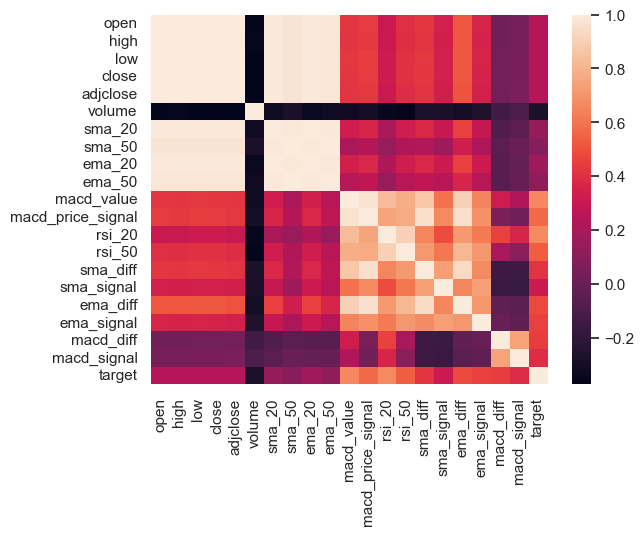

In [39]:
stock_corr = stock_df.corr(numeric_only=True)
sns.heatmap(stock_corr)

### 4cii. With Respect To Target Column

In [40]:
stock_corr_abs = stock_corr.abs()
stock_corr_abs['target'].sort_values(ascending=False)[1:]

rsi_20               0.664626
macd_value           0.656996
macd_price_signal    0.568177
rsi_50               0.533567
ema_diff             0.474351
ema_signal           0.455040
macd_diff            0.446034
sma_diff             0.411804
macd_signal          0.393165
sma_signal           0.309446
volume               0.274407
low                  0.243359
close                0.239448
open                 0.238639
adjclose             0.238289
high                 0.234320
ema_20               0.171871
sma_20               0.137571
ema_50               0.124479
sma_50               0.093666
Name: target, dtype: float64

### 4ciii. Remove Low to No Correlation Columns
Since all the individual indicator columns (except RSI) and volume column are of low to no correlation to the target, we will remove these columns to minimize unneccessary noise in our data. We will also keep a copy of the full dataset for data visualisation in the later sections

In [41]:
full_stock_df = stock_df.copy()
stock_df = stock_df.drop(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume', 'sma_20', 'sma_50', 'ema_20', 'ema_50'])
stock_df

date  macd_value  macd_price_signal     rsi_20     rsi_50  \
0     2014-09-23    0.000000           0.000000        NaN        NaN   
1     2014-09-24   -0.004992          -0.002773        NaN        NaN   
2     2014-09-25   -0.036440          -0.016571        NaN        NaN   
3     2014-09-26   -0.023855          -0.019039        NaN        NaN   
4     2014-09-29   -0.022881          -0.020182        NaN        NaN   
...          ...         ...                ...        ...        ...   
1323  2019-12-24    1.656653           1.501481  72.396576  67.190754   
1324  2019-12-26    1.781618           1.557508  75.618908  68.708110   
1325  2019-12-27    1.857027           1.617412  75.438087  68.644920   
1326  2019-12-30    1.929248           1.679779  76.368056  69.098308   
1327  2019-12-31    2.006325           1.745089  77.479561  69.652815   

      sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  macd_signal  \
0          NaN       False  0.000000       False   0.000000        False   
1          NaN       False -0.003337       False  -0.002219        False   
2          NaN       False -0.024168       False  -0.019869        False   
3          NaN       False -0.016835       False  -0.004817        False   
4          NaN       False -0.016571       False  -0.002700        False   
...        ...         ...       ...         ...        ...          ...   
1323  2.858649        True  3.248426        True   0.155172         True   
1324  2.905949        True  3.349748        True   0.224109         True   
1325  2.903299        True  3.423775        True   0.239615         True   
1326  2.925474        True  3.499427        True   0.249469         True   
1327  3.007899        True  3.581952        True   0.261236         True   

      target  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
1323    True  
1324    True  
1325    True  
1326    True  
1327    True  

[1328 rows x 12 columns]

### 4civ. Filter Dataset to Only Include Entries From 2015-01-01 to 2019-12-31
For our project, we will only be focussing on trading days between 2015-01-01 and 2019-12-31, hence we will have to remove other columns whose dates do not lie within this range.

In [42]:
data_dir = '/'
full_stock_df = full_stock_df[start_date <= full_stock_df['date']]
full_stock_df = full_stock_df.reset_index(drop=True)
stock_df = stock_df[start_date <= stock_df['date']]
stock_df = stock_df.reset_index(drop=True)
stock_df.to_csv(f'{data_dir}aapl_stock_cleaned.csv')
stock_df

date  macd_value  macd_price_signal     rsi_20     rsi_50  \
0     2015-01-02   -0.054420           0.010108  45.815963  51.201749   
1     2015-01-05   -0.159254          -0.023765  40.582154  47.960590   
2     2015-01-06   -0.239371          -0.066886  40.605348  47.971504   
3     2015-01-07   -0.269786          -0.107466  44.031173  49.578887   
4     2015-01-08   -0.208214          -0.127615  52.110085  53.639699   
...          ...         ...                ...        ...        ...   
1253  2019-12-24    1.656653           1.501481  72.396576  67.190754   
1254  2019-12-26    1.781618           1.557508  75.618908  68.708110   
1255  2019-12-27    1.857027           1.617412  75.438087  68.644920   
1256  2019-12-30    1.929248           1.679779  76.368056  69.098308   
1257  2019-12-31    2.006325           1.745089  77.479561  69.652815   

      sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  macd_signal  \
0     0.049325        True  0.201872        True  -0.064528        False   
1    -0.082475       False  0.116552        True  -0.135489        False   
2    -0.198875       False  0.042139        True  -0.172485        False   
3    -0.269650       False -0.002563       False  -0.162320        False   
4    -0.331425       False  0.014529        True  -0.080598        False   
...        ...         ...       ...         ...        ...          ...   
1253  2.858649        True  3.248426        True   0.155172         True   
1254  2.905949        True  3.349748        True   0.224109         True   
1255  2.903299        True  3.423775        True   0.239615         True   
1256  2.925474        True  3.499427        True   0.249469         True   
1257  3.007899        True  3.581952        True   0.261236         True   

      target  
0       True  
1       True  
2       True  
3      False  
4      False  
...      ...  
1253    True  
1254    True  
1255    True  
1256    True  
1257    True  

[1258 rows x 12 columns]

In [43]:
stock_df.isnull().sum()

date                 0
macd_value           0
macd_price_signal    0
rsi_20               0
rsi_50               0
sma_diff             0
sma_signal           0
ema_diff             0
ema_signal           0
macd_diff            0
macd_signal          0
target               0
dtype: int64

## 4d. Methodology
### 4di. Split Dataset into Train, Validation, and Test Dataset

Since our dataset is a time series data, we will not randomly select parts of our dataset as our train data, instead, we will select the earliest 60% of our dataset as our train dataset, the next 20% as our validation dataset, and use the remaining latest 20% of our dataset as our test dataset. The train dataset will consist of data from 2015-01-02 to 2017-12-28, the validation dataset will consist of data from 2017-12-29 to 2018-12-31, whereas the test dataset will consist of data from 2019-01-02 to 2019-12-31.

The input will include the following features:
- macd_value
- macd_price_signal
- rsi_20
- rsi_50
- sma_diff
- sma_signal
- ema_diff
- ema_signal
- macd_diff
- macd_signal

The output will be a buy or sell signal:
- 1 = Buy
- 0 = Sell

In [44]:
valid_index = int(len(stock_df) * 0.6)
test_index = int(len(stock_df) * 0.8)

train_data = stock_df[:valid_index]
train_data.to_csv(f'{data_dir}aapl_stock_train.csv')
train_start = train_data.iloc[0].date
train_end = train_data.iloc[-1].date
x_train = train_data.drop(columns=['date', 'target'])
y_train = train_data['target']

valid_data = stock_df[valid_index:test_index]
valid_data.to_csv(f'{data_dir}aapl_stock_validation.csv')
valid_start = valid_data.iloc[0].date
valid_end = valid_data.iloc[-1].date
x_valid = valid_data.drop(columns=['date', 'target'])
y_valid = valid_data['target']

test_data = stock_df[test_index:]
test_data.to_csv(f'{data_dir}aapl_stock_test.csv')
test_start = test_data.iloc[0].date
test_end = test_data.iloc[-1].date
x_test = test_data.drop(columns=['date', 'target'])
y_test = test_data['target']

x_cols = train_data.columns
y_classes = ['Sell', 'Buy']

In [45]:
print(f'''Train Dataset from {train_start} to {train_end}
Shape of Train Dataset = {train_data.shape}
Shape of X Train Data = {x_train.shape}
Shape of Y Train Data = {y_train.shape}

Validation Dataset from {valid_start} to {valid_end}
Shape of Validation Dataset = {valid_data.shape}
Shape of X Validation Data = {x_valid.shape}
Shape of Y Validation Data = {y_valid.shape}

Test Dataset from {test_start} to {test_end}
Shape of Test Dataset = {test_data.shape}
Shape of X Test Data = {x_test.shape}
Shape of Y Test Data = {y_test.shape}''')

Train Dataset from 2015-01-02 to 2017-12-28
Shape of Train Dataset = (754, 12)
Shape of X Train Data = (754, 10)
Shape of Y Train Data = (754,)

Validation Dataset from 2017-12-29 to 2018-12-31
Shape of Validation Dataset = (252, 12)
Shape of X Validation Data = (252, 10)
Shape of Y Validation Data = (252,)

Test Dataset from 2019-01-02 to 2019-12-31
Shape of Test Dataset = (252, 12)
Shape of X Test Data = (252, 10)
Shape of Y Test Data = (252,)


## 4e. Random Forest Classifier Model
Random forest is a popular and powerful ensemble learning method for classification tasks. It is a type of decision tree algorithm that combines the predictions of multiple decision trees to make a final classification decision. The "forest" in random forest is a collection of decision trees, each of which is trained on a random subset of the data and a random subset of the input features. During training, each decision tree is grown using a process called recursive partitioning, where the algorithm splits the data into smaller and smaller subsets based on the values of the input features.

The key idea behind random forests is that by averaging the predictions of multiple decision trees, the final prediction is less sensitive to the noise or variation in any one tree. This helps to reduce overfitting and increase the model's generalization performance. In the case of classification tasks, the final prediction of a random forest is typically determined by majority voting. This means that each tree's prediction is counted as a "vote" for a particular class, and the class with the most votes is chosen as the final prediction.

Lastly, random forest models can provide information about the relative importance of each feature in making the classification decision. This could be useful in feature selections or increasing the interpretability of the model.

### 4ei. Obtain Hyperparamenters for Random Forest Classifier Model
For a start, we will be using the default hyperparameters for the RandomForestClassifier model.

In [46]:
randfor_model = RandomForestClassifier(n_jobs=-1, random_state=random_state)
randfor_model_params = randfor_model.get_params()
randfor_model_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

### 4eii. Train, Validate and Test RandomForestClassifier Model
We have chosen to use the RandomForestClassifier Model as our base model due to its ability to model complex decision boundaries by combining the predictions of multiple decision trees. This is particularly useful since the relationship between our dataset's input features and our target variable is non-linear. 

After fitting the model to our x_train and y_train dataset, we will use the trained model to make classification based on x_valid, and compare the predicted results with the true target values y_valid. From there, we can then manually tune the model's hyperparamters to maximize its performance. Afterwards, we will use the tuned model to run classification on x_test, compare these classification to the true values, y_test, and measure the model's effectiveness by calculating the Accuracy, TPR, TNR, FPR and FNR of its classification.

In [47]:
def train_test_eval(model, x_train, y_train, x_test, y_test, dataset, test_data=full_stock_df, valid_index=valid_index, test_index=test_index):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_confmat = confusion_matrix(y_test, model_pred)
    model_confmat_dp = ConfusionMatrixDisplay(model_confmat)
    model_confmat_dp.plot()
    model_confmat_dp.ax_.set_title(f'Confusion Matrix for {type(model).__name__} Model on {dataset} Dataset');

    TN, FP, FN, TP = model_confmat[0][0], model_confmat[0][1], model_confmat[1][0], model_confmat[1][1]
    model_metrics = {
        'Accuracy': round((TP + TN) / (TP + FP + TN + FN), 4),
        'TPR': round(TP / (TP + FN), 4),
        'TNR': round(TN / (TN + FP), 4),
        'FPR': round(FP / (FP + TN), 4),
        'FNR': round(FN / (TP + FN), 4),
    }

    for metric in model_metrics:
        print(f'{metric} = {model_metrics[metric]}')

    if dataset == 'Train':
        test_data = test_data[:valid_index].copy()
    elif dataset == 'Validation':
        test_data = test_data[valid_index:test_index].copy()
    else:
        test_data = test_data[test_index:].copy()
    test_data['pred'] = model_pred
    test_fig = plotCandle(test_data)
    test_fig = plotSignals(test_fig, test_data, 'target', id=1)
    test_fig = plotSignals(test_fig, test_data, 'pred', id=2)
    test_fig.update_layout(title_text=f'True VS Predicted Buy and Sell Signals on {dataset} Dateset for {type(model).__name__}')

    return model_metrics, model_confmat, model_pred, test_fig

train_results = {}
valid_results = {}
test_results = {}

### 4eiii. RandomForestClassfier Training Results
The RandomForestClassfier model seems to have exactly fit our training dataset and achieve the following the results on the training dataset:
- Perfect Accuracy of 1.0
- Perfect TPR of 1.0
- Perfect TNR of 1.0
- Perfect FPR of 0.0
- Perfect FNR of 0.0

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


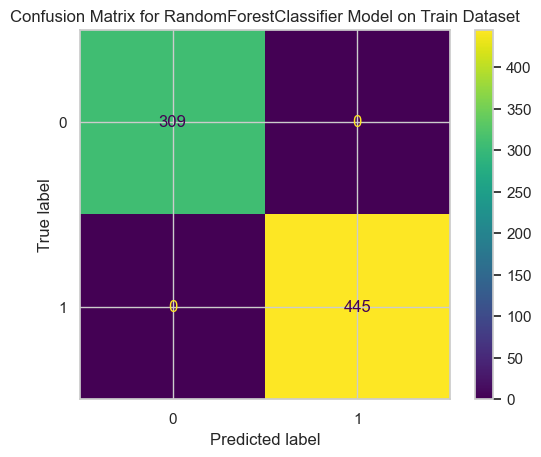

In [48]:
randfor_train_metrics, randfor_train_confmat, randfor_train_pred, randfor_train_fig = train_test_eval(randfor_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(randfor_model).__name__}'] = randfor_train_metrics
randfor_train_fig.show()

### 4eiv. RandomForestClassifier Validation Results
Our RandomForestClassifier model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8651
- High TPR of 0.8806
- High TNR of 0.8475
- Low FPR of 0.1525
- Low FNR of 0.1194

One noteworthy observation is that our RandomForestClassifier model managed to perfectly fit our training dataset, hence when comparing the results of our validation to our training, the model performed significantly worse. Given that tree-based models are more prone to overfitting compared to other models, it is likely that our model has over-fitted our training dataset, making it more affected by outliers and unneccessary noise in our data.

Accuracy = 0.8651
TPR = 0.8806
TNR = 0.8475
FPR = 0.1525
FNR = 0.1194


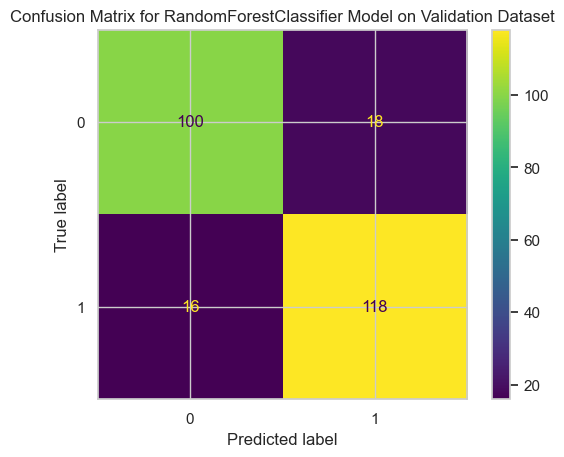

In [49]:
randfor_valid_metrics, randfor_valid_confmat, randfor_valid_pred, randfor_valid_fig = train_test_eval(randfor_model, x_train, y_train, x_valid, y_valid, 'Validation')
randfor_valid_fig.show()

## 4ev. Tune RandomForestClassifier's HyperParameters
After manual trial and error on various hyperparameters for the RandomForestClassifier model, we have found that the best modification to the model would be to change its n_estimators value from the default 100 to 150. 

In the RandomForestClassifier model:
- n_estimators represents the number of trees to have in the forest. In this case, having more trees was beneficial as it likely allowed the model to capture the general trends more effectively and reduce overfitting, making the model less affected by outliers or unneccessary noise in our data and increasing the accuracy of our model.

Our tuned RandomForestClassifier model managed to achieve the following results on the following dataset:
- High Accuracy of 0.873
- High TPR of 0.8806
- High TNR of 0.8644
- Low FPR of 0.1356
- Low FNR of 0.1194

Comparing the tuned model to the original model, our tuned RandomForestClassifier model has improved in the following ways:
- Accuracy increased by 0.0079
- TNR increased by 0.0169
- FPR decreased by 0.0169

Accuracy = 0.873
TPR = 0.8806
TNR = 0.8644
FPR = 0.1356
FNR = 0.1194


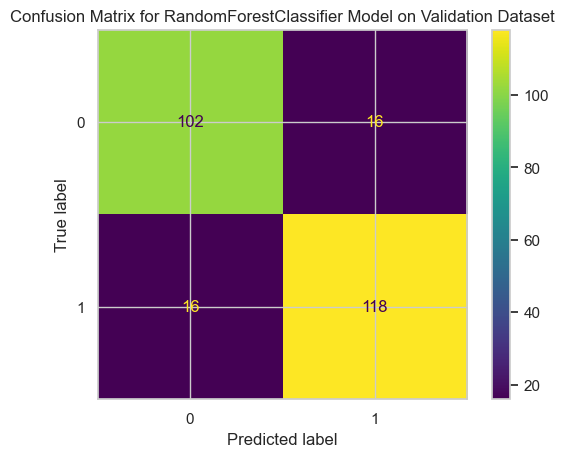

In [50]:
randfor_tuned_model = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=150)
randfor_tuned_metrics, randfor_tuned_confmat, randfor_tuned_pred, randfor_tuned_fig = train_test_eval(randfor_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(randfor_tuned_model).__name__}'] = randfor_tuned_metrics
randfor_tuned_fig.show()

### 4evi. RandomForestClassifier Test Results
The RandomForestClassifier model has managed to achieved the following results in the final test dataset:
- High Accuracy of 0.9325
- High TPR of 0.9375
- High TNR of 0.9091
- Low FPR of 0.0909
- Low FNR of 0.0625

Accuracy = 0.9325
TPR = 0.9375
TNR = 0.9091
FPR = 0.0909
FNR = 0.0625


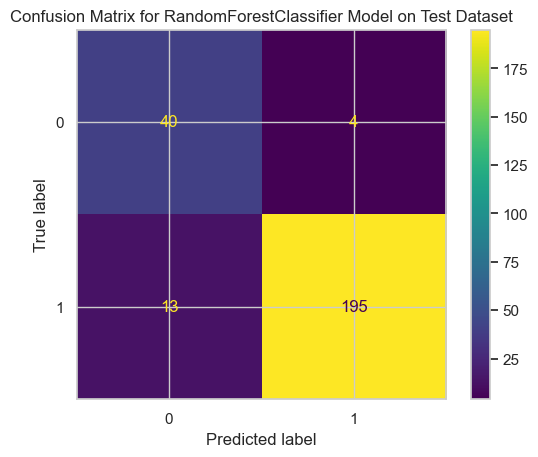

In [51]:
randfor_test_metrics, randfor_test_confmat, randfor_test_pred, randfor_test_fig = train_test_eval(randfor_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(randfor_tuned_model).__name__}'] = randfor_test_metrics
randfor_test_fig.show()

## 4evii. RandomForestClassifier Feature Importances
It seems the most important variables that the model used to classify the buy and sell decisions were the macd_value, rsi_20 and macd_price_signal.

In [52]:
def plotBar(x, y, title):
    fig = go.Figure()
    fig.add_bar(
        x=x,
        y=y,
    )
    fig.update_layout(title_text=title)
    fig.show()
    return fig

randfor_impt_fig = plotBar(
    x_train.columns, 
    randfor_model.feature_importances_, 
    'Feature Importances of RandomForestClassifier',
    )

## 4f. Experiments
For our experiments, we will be experimenting with 3 different classification models:
- DecisionTreeClassifier
- SGDClassifier
- LogisticRegression

To measure the effectiveness of our experiments and compare them with our baseline RandomForestClassifier model, we will be using the following metrics:
- Accuracy = Proportion of predictions that are correctly predicted as True and correctly predicted as False = (TP + TN) / (TP + TN + FP + FN)
- TPR = The probability that an actual positive will be predicted as positive = (TP / (TP + FN))
- TNR = The probability that an actual negative will be predicted as negative = (TN / (TN + FP))
- FPR = The probability that an actual negative will be predicted as positive = (FP / (FP + TN))
- FNR = The probability that an actual positive will be predicted as negative = (FN / (TP + FN))

Since accuracy is the metric that accounts for both true positive and true negatives out of all the predictions made, we will first prioritise the accuracy metric over all the other metrics in comparing model performance.

After analysing each model's effectiveness, we will attempt to tune the hyperparameters of all our models to maximize each model's performance using our validation dataset. Once all the models are tuned, we will then test the tuned model using our final test dataset.

## 4fi. DecisionTreeClassifier Model
The DecisionTreeClassifier is a classification algorithm that belongs to the family of tree-based models. It builds a decision tree by recursively splitting the data into subsets based on the values of different input features, and then assigning a label to each subset based on the majority class within it. This process is repeated until all instances in the data have been assigned a label. The algorithm works by selecting the best feature to split the data based on some criteria (such as information gain or Gini impurity) at each node. This process is repeated for each resulting subset until a stopping criterion is met, such as reaching a minimum number of instances in a leaf node or a maximum depth for the tree.

The advantage to this model is its ability to use different subsets of features by breaking down complex data into smaller parts, as well as utilise different rules in making its decisions at different stages of classification. This could be particularly useful if the data has a large amount of data and a high number of highly-correlated variables that could significantly affect the model's ability to make decisions.

Overall, the DecisionTreeClassifier is a powerful and interpretable model that can handle both categorical and continuous input features. It can also handle missing values, although some techniques such as imputation may need to be used to handle these missing values.

#### Obtain HyperParameters for DecisionTreeClassifier Model
As a start, we will use the default hyperparameters for the DecisionTreeClassifier model.

In [53]:
dectree_model = DecisionTreeClassifier(random_state=random_state)
dectree_model_params = dectree_model.get_params()
dectree_model_params

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

#### Train, Validate and Test DecisionTreeClassifier Model
The DecisionTreeClassifier model is a possible model we could use since our dataset consists of quite a number of variables that are medium to highly correlated to our target buy or sell signal.

##### DecisionTreeClassifier Training Results
The DecisionTreeClassifier model seems to exactly fit our training dataset and achieve the following results on the training dataset:
- Perfect Accuracy of 1.0
- Perfect TPR of 1.0
- Perfect TNR of 1.0
- Perfect FPR of 0.0
- Perfect FNR of 0.0

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


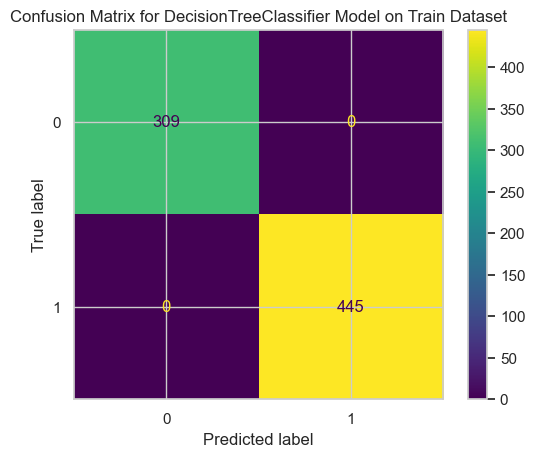

In [54]:
dectree_train_metrics, dectree_train_confmat, dectree_train_pred, dectree_train_fig = train_test_eval(dectree_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(dectree_model).__name__}'] = dectree_train_metrics
dectree_train_fig.show()

##### Visualise the DecisionTreeClassifier Model
This allows us to visualise exactly how this model makes it decisions and classifies the data into a buy or a sell signal. By observation, there are a total of 44 leaf nodes in the decision tree.

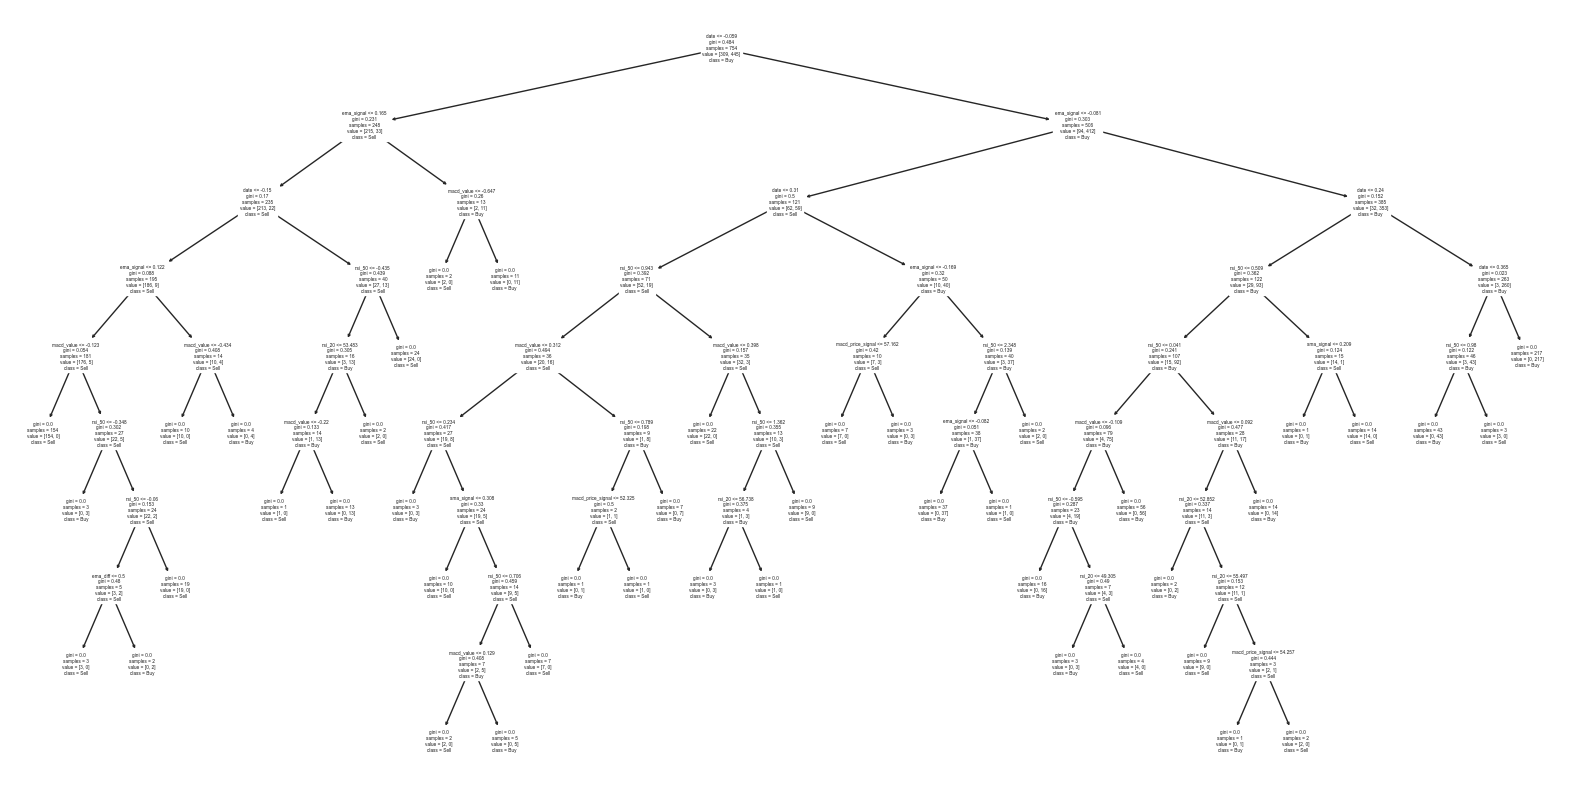

In [55]:
plt.figure(figsize=(20, 10))
plot_tree(dectree_model, feature_names=x_cols, class_names=y_classes);

##### DecisionTreeClassifier Validation Results
Our DecisionTreeClassifier model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8889
- High TPR of 0.903
- High TNR of 0.8729
- Low FPR of 0.1271
- Low FNR of 0.097

Similar to our baseline RandomForestClassifier model, our DecisionTreeClassifier model has also perfectly fit our training datase. Thus, when comparing the validation results to the training results, the model has performed significantly worse on our validation dataset. This could also be due to the DecisionTreeClassifier overfitting our training data, hindering its prediction ability on new, unseen data.

Accuracy = 0.8889
TPR = 0.903
TNR = 0.8729
FPR = 0.1271
FNR = 0.097


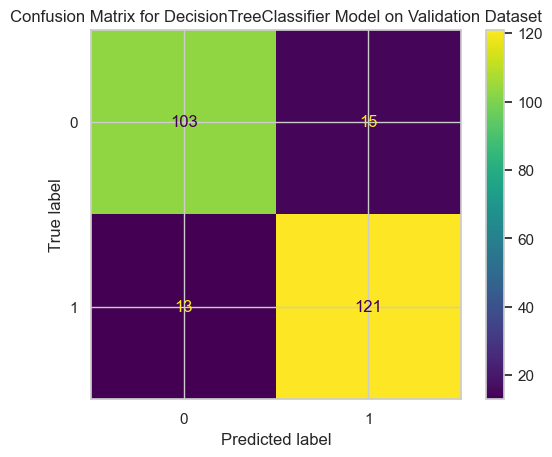

In [56]:
dectree_valid_metrics, dectree_valid_confmat, dectree_valid_pred, dectree_valid_fig = train_test_eval(dectree_model, x_train, y_train, x_valid, y_valid, 'Validation')
dectree_valid_fig.show()

##### Tune DecisionTreeClassifier HyperParameters
After manual trial and error on various hyperparameters for the DecisionTreeClassifier model, we have found that the best modification to the model would be to were increasing the min_samples_leaf from 1 to 3, and limiting the max_leaf_nodes to 35. 

In the DecisionTreeClassifier model:
- min_samples_leaf represents the minimum number of samples required to be at a leaf node. By increasing this value, our DecisionTreeClassifier model will have fewer leaf nodes since each leaf node must now have a minimum number of samples in order to make a decision, which decreases overfitting of the model on our data.
- max_leaf_nodes represents the maximum number of leaf nodes that the model can have. In our case, decreasing it simplified our DecisionTreeClassifier model and made it less prone to overfitting, which hence improves its prediction ability on new, unseen data like our test dataset.

Our tuned DecisionTreeClassifier model managed to achieve the following results on the following dataset:
- High Accuracy of 0.9087
- High TPR of 0.9403
- High TNR of 0.8729
- Low FPR of 0.1271
- Low FNR of 0.0597

Comparing the tuned model to the original model, our tuned DecisionTreeClassifier model has improved in the following ways:
- Accuracy increased by 0.0198
- TPR increased by 0.0373
- FNR decreased by 0.0373

Accuracy = 0.9087
TPR = 0.9403
TNR = 0.8729
FPR = 0.1271
FNR = 0.0597


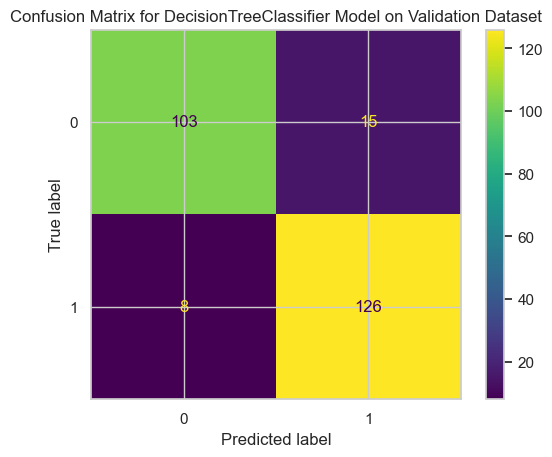

In [57]:
dectree_tuned_model = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=3, max_leaf_nodes=35)
dectree_tuned_metrics, dectree_tuned_confmat, dectree_tuned_pred, dectree_tuned_fig = train_test_eval(dectree_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(dectree_tuned_model).__name__}'] = dectree_tuned_metrics
dectree_tuned_fig.show()

##### Visualise the Tuned DecisionTreeClassifier Model
After tuning, we can observe that there only 35 leaf nodes, as compared to the previous 44 leaf nodes, which indicates that our model is now less over-fitted.

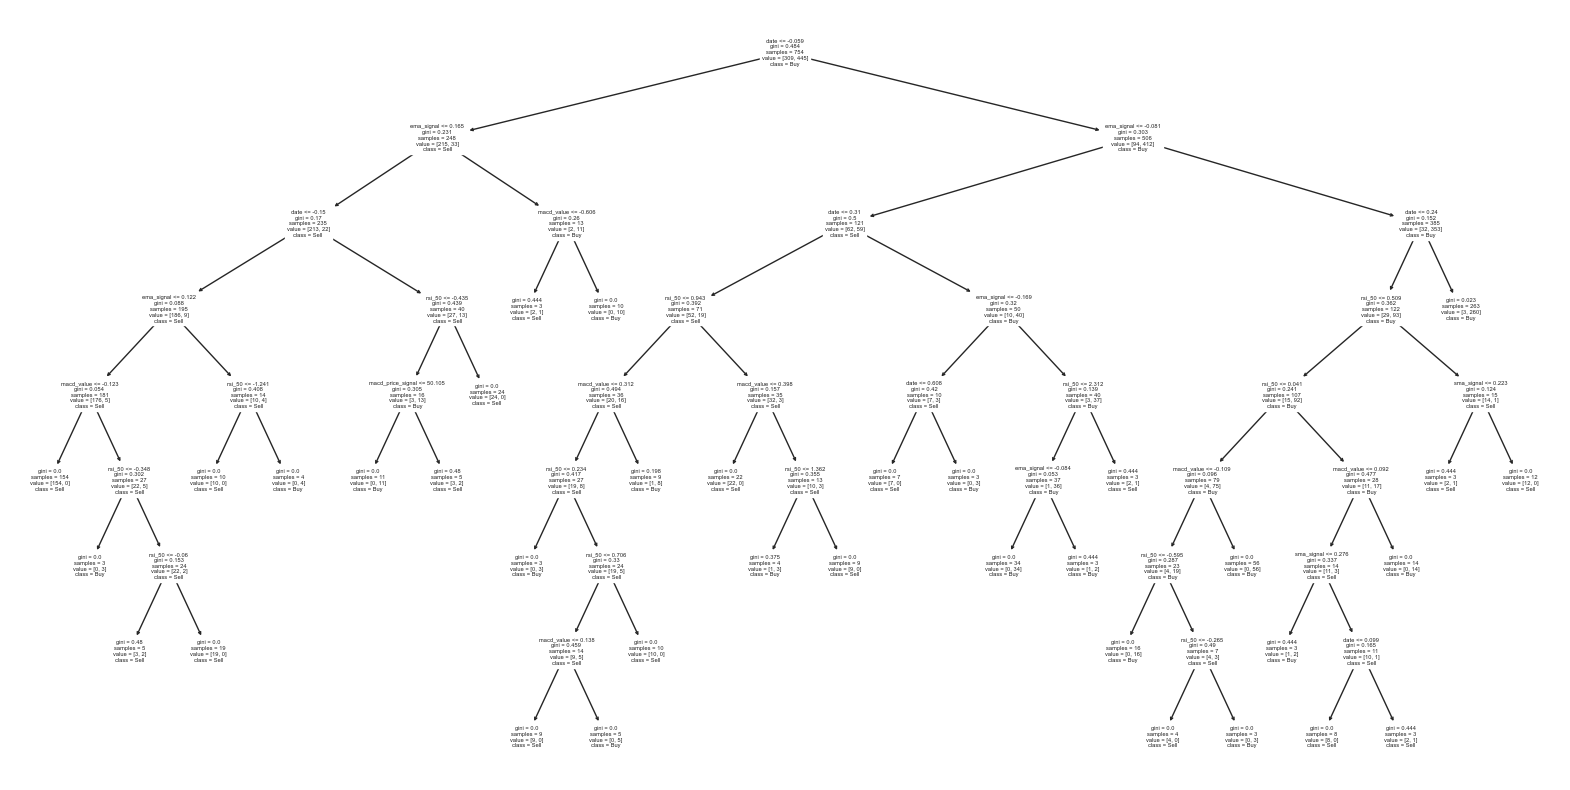

In [58]:
plt.figure(figsize=(20, 10))
plot_tree(dectree_tuned_model, feature_names=x_cols, class_names=y_classes);

##### DecisionTreeClassifier Test Results
Our DecisionTreeClassifier model has managed to achieve the following results on the final test dataset:
- High Accuracy of 0.9286
- High TPR of 0.9183
- High TNR of 0.9773
- Low FPR of 0.0227
- Low FNR of 0.0817

Accuracy = 0.9286
TPR = 0.9183
TNR = 0.9773
FPR = 0.0227
FNR = 0.0817


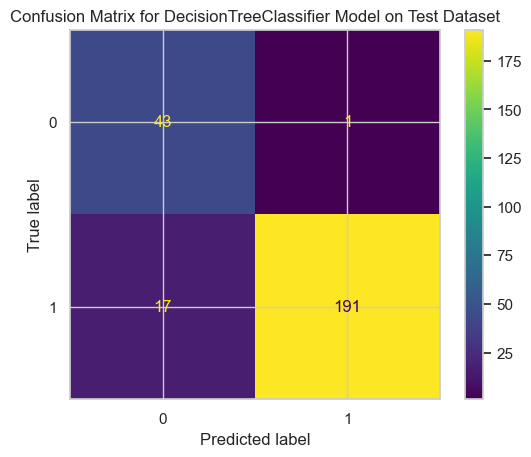

In [59]:
dectree_test_metrics, dectree_test_confmat, dectree_test_pred, dectree_test_fig = train_test_eval(dectree_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(dectree_tuned_model).__name__}'] = dectree_test_metrics
dectree_test_fig.show()

##### DecisionTreeClassifier Feature Importances
It seems the top 3 features that were important in the classification decision were macd_value, sma_diff and macd_diff.

In [60]:
dectree_impt_fig = plotBar(
    x_train.columns, 
    dectree_tuned_model.feature_importances_, 
    'Feature Importances of DecisionTreeClassifier',
    )

### 4fii. The SGDClassifier Model
SGDClassifier stands for Stochastic Gradient Descent Classifier. It is a linear classifier that is trained using stochastic gradient descent. This means that during the training process, the model updates its parameters based on small batches of training data instead of the entire dataset at once. It supports different loss functions, such as hinge loss (for linear SVM) and log loss (for logistic regression), and it can handle both binary and multiclass classification problems effectively as well.

The main advantage of this model is its efficiency in large-scale and sparse datasets, as well as its ability to handle high-dimensional data with ease. 

#### Obtain HyperParameters for SGDClassifier Model
As a start, we will user the default hyperparameters for the SGDClassifier model.

In [61]:
sgd_model = SGDClassifier(n_jobs=-1, random_state=random_state)
sgd_model_params = sgd_model.get_params()
sgd_model_params

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Train, Validate and Test SGDClassifier Model
Since our dataset is has many data features, this model would be able to fit onto our data more effectively and efficienctly compared to other models, which could lead to strong classification ability.

##### SGDClassifier Training Results
Our SGDClassifier model has managed to achieve the following results on our training dataset:
- High Accuracy of 0.8541
- High TPR of 0.8157
- High TNR of 0.9094
- Low FPR of 0.0906
- Low FNR of 0.1843

Accuracy = 0.8541
TPR = 0.8157
TNR = 0.9094
FPR = 0.0906
FNR = 0.1843


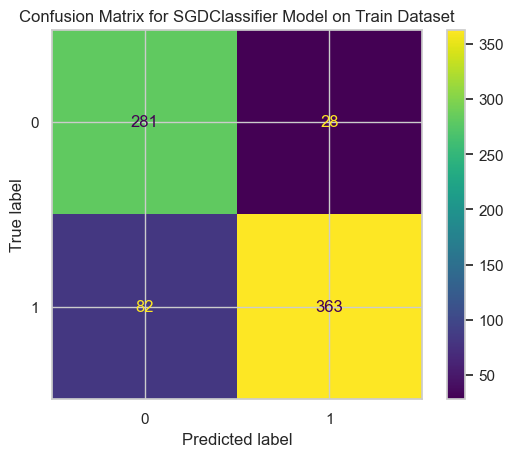

In [62]:
sgd_train_metrics, sgd_train_confmat, sgd_train_pred, sgd_train_fig = train_test_eval(sgd_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(sgd_model).__name__}'] = sgd_train_metrics
sgd_train_fig.show()

##### SGDClassifier Validation Results
Our SGDClassifier model has managed to achieve the following results on our validation dataset:
- High Accuracy of 0.8294
- High TPR of 0.8284
- High TNR of 0.8305
- Low FPR of 0.1695
- Low FNR of 0.1716

These validation results are comparable to our training dataset, which is an indicator that our model is not over or under-fitted on our data.

Accuracy = 0.8294
TPR = 0.8284
TNR = 0.8305
FPR = 0.1695
FNR = 0.1716


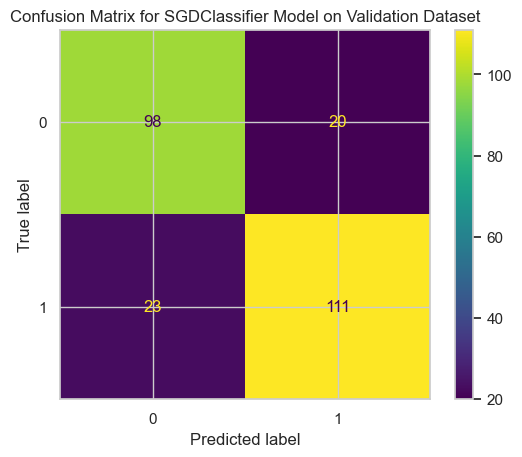

In [63]:
sgd_valid_metrics, sgd_valid_confmat, sgd_valid_pred, sgd_valid_fig = train_test_eval(sgd_model, x_train, y_train, x_valid, y_valid, 'Validation')
sgd_valid_fig.show()

##### Tune SGDClassifier HyperParameters
After manually tuning the hyperparameter, we have found that the default hyperparameters still performed the best, hence we will not be making any modifications to this model

Accuracy = 0.8294
TPR = 0.8284
TNR = 0.8305
FPR = 0.1695
FNR = 0.1716


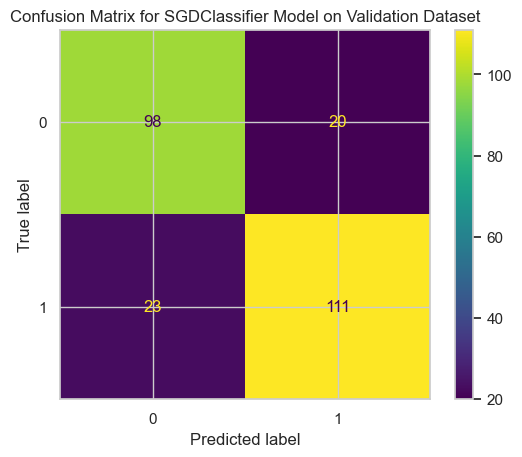

In [64]:
sgd_tuned_model = SGDClassifier(n_jobs=-1, random_state=random_state)
sgd_tuned_metrics, sgd_tuned_confmat, sgd_tuned_pred, sgd_tuned_fig = train_test_eval(sgd_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(sgd_tuned_model).__name__}'] = sgd_tuned_metrics
sgd_tuned_fig.show()

##### SGDClassifier Test Results
Our SGDClassifier model has managed to achieve the following results on our final test dataset:
- High Accuracy of 0.9405
- High TPR of 0.9423
- High TNR of 0.9318
- Low FPR of 0.0682
- Low FNR of 0.0577

Accuracy = 0.9405
TPR = 0.9423
TNR = 0.9318
FPR = 0.0682
FNR = 0.0577


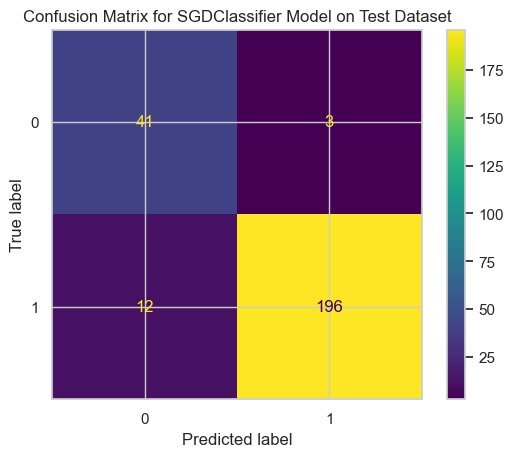

In [66]:
sgd_test_metrics, sgd_test_confmat, sgd_test_pred, sgd_test_fig = train_test_eval(sgd_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(sgd_tuned_model).__name__}'] = sgd_test_metrics
sgd_test_fig.show()

##### SGDClassifier Feature Coefficients
As a larger coefficient could lead to a greater change in the result of a classification decision, we will relate a higher feature coefficient with higher importance. Hence, the top 3 most important variables were the macd_value, ema_diff and macd_price_signal.

In [67]:
sgd_coef_fig = plotBar(
    x_train.columns, 
    sgd_tuned_model.coef_[0], 
    'Feature Coefficients of SGDClassifier',
    )

### 4fiii. Logistic Regression Model
LogisticRegression is a linear model that is used for binary classification. It uses the logistic function (also known as sigmoid function) to predict the probability of an input sample belonging to the positive class. The logistic function maps any input value to a value between 0 and 1, which represents the probability of the positive class. 

The main advantage of this model is its interpretability, as it provides the coefficients of the input features, which can be used to interpret the importance of each feature in the classification task.

#### Obtain HyperParameters for LogisticRegression Model
As a start, we will use the default hyperparameters for the LogisticRegression model.

In [68]:
logreg_model = LogisticRegression(n_jobs=-1, random_state=random_state)
logreg_model_params = logreg_model.get_params()
logreg_model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Train, Validate and Test LogisticRegression Model
The LogisticRegression model could be beneficial since it is a model designed for binary classification, and we only have binary target results, buy and sell. In addition, our data has many medium to high correlation features, so this model could help us to identify which features are more important and affect the decision making process in classifying a buy or sell signal.

#### Train, Validate and Test LogisticRegression Model
The LogisticRegression model could be beneficial since it is a model designed for binary classification, and we only have binary target results, buy and sell. In addition, our data has many medium to high correlation features, so this model could help us to identify which features are more important and affect the decision making process in classifying a buy or sell signal.

##### LogisticRegression Training Results
Our LogisticRegression model has managed to achieve the following results on our training dataset:
- High Accuracy of 0.9164
- High TPR of 0.9258
- High TNR of 0.9029
- Low FPR of 0.0971
- Low FNR of 0.0742

Accuracy = 0.9138
TPR = 0.9258
TNR = 0.8964
FPR = 0.1036
FNR = 0.0742


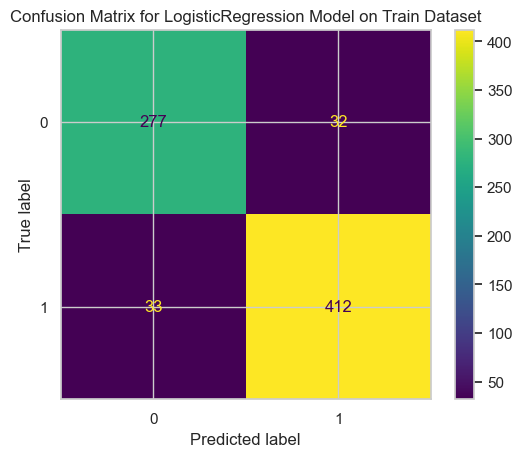

In [69]:
logreg_train_metrics, logreg_train_confmat, logreg_train_pred, logreg_train_fig = train_test_eval(logreg_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(logreg_model).__name__}'] = logreg_train_metrics
logreg_train_fig.show()

##### LogisticRegression Validation Results
Our LogisticRegression model has managed to achieve the following results on our validation dataset:
- High Accuracy of 0.8889
- High TPR of 0.9179
- High TNR of 0.8559
- Low FPR of 0.1441
- Low FNR of 0.0821

These validation results are comparable to our training dataset, which indicates that our model is likely not over or under-fitted on our data.

Accuracy = 0.8889
TPR = 0.9179
TNR = 0.8559
FPR = 0.1441
FNR = 0.0821


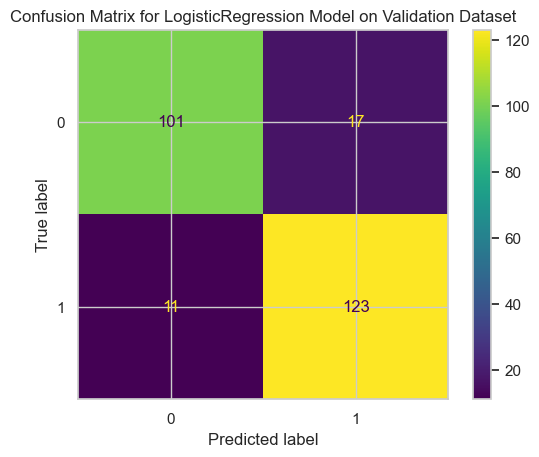

In [70]:
logreg_valid_metrics, logreg_valid_confmat, logreg_valid_pred, logreg_valid_fig = train_test_eval(logreg_model, x_train, y_train, x_valid, y_valid, 'Validation')
logreg_valid_fig.show()

##### Tune LogisticRegression HyperParameters
After manually tuning the hyperparameters, we have found that the default hyperparameters still performed the best, hence we will not make any modifications to this model.

Accuracy = 0.8889
TPR = 0.9179
TNR = 0.8559
FPR = 0.1441
FNR = 0.0821


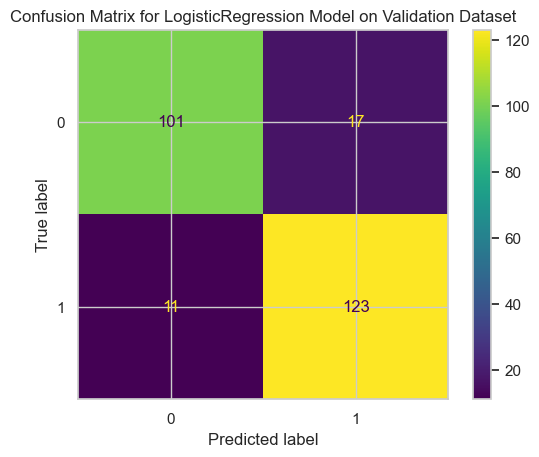

In [72]:
logreg_tuned_model = LogisticRegression(n_jobs=-1, random_state=random_state)
logreg_tuned_metrics, logreg_tuned_confmat, logreg_tuned_pred, logreg_tuned_fig = train_test_eval(logreg_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(logreg_tuned_model).__name__}'] = logreg_tuned_metrics
logreg_tuned_fig.show()

##### LogisticRegression Test Results
Our LogisticRegression model has managed to achieve the following results on our final test dataset:
- High Accuracy of 0.9563
- High TPR of 0.9615
- High TNR of 0.9318
- Low FPR of 0.0682
- Low FNR of 0.0385

Accuracy = 0.9563
TPR = 0.9615
TNR = 0.9318
FPR = 0.0682
FNR = 0.0385


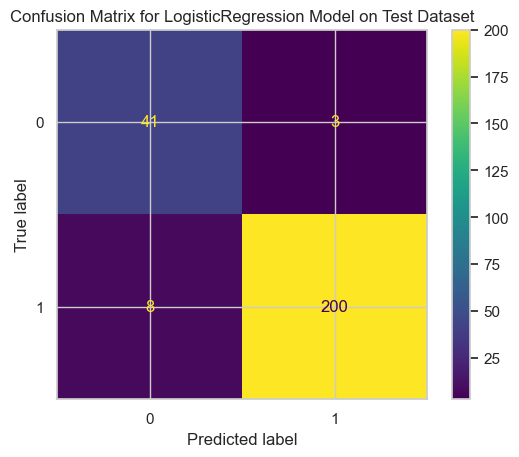

In [74]:
logreg_test_metrics, logreg_test_confmat, logreg_test_pred, logreg_test_fig = train_test_eval(logreg_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(logreg_tuned_model).__name__}'] = logreg_test_metrics
logreg_test_fig.show()

##### LogisticRegression Feature Coefficients
As a larger coefficient could lead to a greater change in the result of a classification decision, we will relate a higher feature coefficient with higher importance. Hence, the top 3 most important variables were the macd_value, macd_price_signal and sma_diff.

In [75]:
logreg_coef_fig = plotBar(
    x_train.columns, 
    logreg_tuned_model.coef_[0], 
    'Feature Coefficients of LogisticRegression',
    )

## 4g. Compare Performance of 4 Technical Analysis Models

### 4gi. Compare the Training Performance
Overall, all our models have managed to fit well on our train dataset, all of them managing to accurately classify a large proportion of at least 80% of our training data into buy and sell signals.

At this stage, we would rank the models in the following order:
- RandomForestClassifier and DecisionTreeClassifier, both had perfect accuracy, TPR and TNR scores
- LogisticRegression, significantly higher accuracy and TPR than the last model, although very slightly lower TNR
- SGDClassifier, significantly lower accuracy and TPR than LogisticRegression, although slightly higher TNR

In [76]:
available_models = train_results.keys()

def plotResults(models, results, dataset):
    results = pd.DataFrame(results).transpose().copy()
    fig = go.Figure()
    for model in models:
        fig.add_bar(
            x=results.columns,
            y=results.loc[model],
            name=model,
        )
    fig.update_layout(title_text=f'Results for all 4 Models on {dataset} Dataset')
    return fig

In [77]:
train_results_fig = plotResults(available_models, train_results, 'Training')
train_results_fig.show()

### 4gii. Compare the Validation Performance
We observed that the RandomForestClassifier and DecisionTreeClassifier models performed significantly worse on the validation dataset compared to the training dataset, hence they were most likely over-fitted on our training dataset. After tuning their hyperparameters, we have managed to reduce the amount and likelihood of overfitting and improve the models' prediction ability on new, unseen data. 

The SGDClassifier and LogisticRegression models had comparable results on the training and validation data, hence were likely not under or over-fitted. We also concluded that the best hyperparameters for those models were their defauly hyperparameters after much trial and error in manually tuning these parameters.

At this stage, we would rank our models in the following order:
- DecisionTreeClassifier, highest accuracy, TPR and TNR
- LogisticRegression, significantly higher accuracy and TPR than the next model, although slightly lower TNR
- RandomForestClassifier, higher accuracy, TPR and TNR than the last model
- SGDClassifier, lowest accuracy, TPR and TNR than all other models

In [78]:
valid_results_fig = plotResults(available_models, valid_results, 'Validation')
valid_results_fig.show()

### 4giii. Compare the Test Performance
In the end, all our models managed to achieve a classification accuracy of at least 0.92, which is a fantastic result as it highlights on all our models' strong classification ability.  

At this stage, we would rank our models in the following order:
- LogisticRegression, highest overall accuracy and TPR, with 2nd highest TNR
- SGDClassifier, 2nd highest overall accuracy and TPR, with highest TNR
- RandomForestClassifier, 3rd highest overall accuracy and TPR
- DecisionTreeClassifier, lowest overall accuracy and TPR, although highest TNR

In [79]:
test_results_fig = plotResults(available_models, test_results, 'Test')
test_results_fig.show()

## 4h. Conclusion (TA)
In this segment, we have effectively identified and calculated relevant technical indicators for AAPL stock, and built an accurate machine learning model that could accurately classify these data into buy and sell signals. To select our best model, we have decided to place a greater weight on the test dataset since it is a dataset that is new and unseen by our model, hence it can give the greatest insight to each model's true performance. We have also decided to place a medium weight on the validation dataset since it is also a dataset that is new and unseen to the original trained models, however, since we used the validation dataset to conduct hyperparameter tuning, and subsequently re-fit our tuned models on our validation dataset, it may not give us the most accurate representation of our model's performance. Lastly, we will place a low weight on the training dataset since it is the dataset that our models are mainly trained on. 

Since the LogisticRegression model performed the best in our final test dataset, and came in the top 2 in our validation dataset, we can conclude that the LogisticRegression model is our best model in terms of its ability to accurately classify AAPL stock data into buy and sell signals, with a final classification accuracy of 0.9563.

In addition to successfully building a model, we also demonstrated how tree-based models such as our baseline RandomForestClassifier and DecisionTreeClassifier models are more prone to overfitting as compared to other models like SGDClassifier and LogisticRegression models, and how we could utilise hyperparameter tuning to mitigate and reduce overfitting. These improve the model's classification ability on new, unseen data as they are more able to capture the general trends of our respective datasets.

We also found that different models will have different decision making processes, and hence will use different features and indicators to make decisions. For example, our baseline RandomForestClassifier's decisions were more influenced by the macd_value, rsi_20 and macd_price_signal, while a similar tree-based model, the DecisionTreeClassifier, placed more emphasis on macd_value, sma_diff and macd_diff.

## 4i. Limitation and Possible Improvements for Technical Analysis Models
One limitation is that there was an imbalance of target buy and sell signals in our data. This could potentially lead to a biasness towards a certain signal, which affects our models' overall classification performance. To mitigate this, we made use of hyperparameter tuning to reduce the likelihood of overfitting in our models, so that our models were more able to capture a general trend in our data, as opposed to being too biased toward a buy or a sell signal. In the future, we could select a timeframe that had a more even balance of buy and sell signals, and use that time frame to conduct our train, validation and test stages for our models, and potentially improve our models' classification accuracy.

# 5. Time Series Forcasting Using Long Short-Term Memory
Although stock prices are prone to fluctuations, stock prices tend to follow trends based on previous days prices and trends, assuming that there is no news that may significantly affect the price of a stock. This resulted in traders buying stocks based on long-term trends of its previous prices, as well as reading candlestick patterns to try to predict the movement of the stock price.

With this observation, we decided to experiement with using long short-term memory networks (LSTM) to predict stock price base on two components - its short term price and it's long term price. Stock prices is a perfect application for LSTM models as it is a time-series data. 

## 5a. Data Preprocessing

### 5ai. Prepare Dataset
We drop all columns except for the date and the close price


In [81]:
close_df = df[['close']]
close_df

close
date                 
2015-01-02  27.332500
2015-01-05  26.562500
2015-01-06  26.565001
2015-01-07  26.937500
2015-01-08  27.972500
...               ...
2019-12-24  71.067497
2019-12-26  72.477501
2019-12-27  72.449997
2019-12-30  72.879997
2019-12-31  73.412498

[1258 rows x 1 columns]

### 5aii. Prepare Training Set and Normalise Data
x_train is an array containing the data as well as the N future prices, as illustrated by the picture. 
![training set](images/training_Set.png)

In [83]:
# Prepare training set
train_df = close_df['2015-01-01':'2018-12-31']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      # Explore using StandardScaler instead of MinMaxScaler in the future
scaled_data = scaler.fit_transform(train_df['close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])

# Convert into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.13398719],
         [0.11225571],
         [0.11232629],
         ...,
         [0.24066886],
         [0.23460098],
         [0.2441967 ]],
 
        [[0.11225571],
         [0.11232629],
         [0.12283922],
         ...,
         [0.23460098],
         [0.2441967 ],
         [0.25894307]],
 
        [[0.11232629],
         [0.12283922],
         [0.15204968],
         ...,
         [0.2441967 ],
         [0.25894307],
         [0.26903268]],
 
        ...,
 
        [[0.89621107],
         [0.93000767],
         [0.92323429],
         ...,
         [0.42609183],
         [0.39857476],
         [0.47153035]],
 
        [[0.93000767],
         [0.92323429],
         [0.8867565 ],
         ...,
         [0.39857476],
         [0.47153035],
         [0.46433354]],
 
        [[0.92323429],
         [0.8867565 ],
         [0.9099696 ],
         ...,
         [0.47153035],
         [0.46433354],
         [0.46489801]]]),
 array([0.25894307, 0.26903268, 0.26218867, 0.25089961,

## 5b. Define LSTM Model
We define our LSTM model using Tensorflow. We set the number of input units as the number of the days we want to base our prediction upon.

In [85]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

### 5bii. Compile Model 
The model is then compiled. We set Mean Sqaured Error to be the loss fuction that we want to minimise.

In [87]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

### 5biii. Train LSTM Model
Next, we train our model for 35 epochs, saving only the best model. 

In [88]:
# Define callbacks, saving only the best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])



Epoch 1/35
29/30 [============================>.] - ETA: 0s - loss: 0.0215
Epoch 1: loss improved from inf to 0.02110, saving model to weights_best.hdf5
30/30 [==============================] - 9s 43ms/step - loss: 0.0211
Epoch 2/35
30/30 [==============================] - ETA: 0s - loss: 0.0051
Epoch 2: loss improved from 0.02110 to 0.00508, saving model to weights_best.hdf5
30/30 [==============================] - 2s 65ms/step - loss: 0.0051
Epoch 3/35
29/30 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 3: loss improved from 0.00508 to 0.00436, saving model to weights_best.hdf5
30/30 [==============================] - 1s 37ms/step - loss: 0.0044
Epoch 4/35
29/30 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 4: loss improved from 0.00436 to 0.00384, saving model to weights_best.hdf5
30/30 [==============================] - 1s 37ms/step - loss: 0.0038
Epoch 5/35
29/30 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 5: loss did not imp

## 5c. Predictions

First we prepare actual_prices, which will contain the actual price of the stock in our testing timeframe, which is 01-01-2019 to 31-12-2019. 

Next, we prepare the model inputs. Our model inputs will include the previous 50 days from the start of the test dataset, which is 18-10-2018. We perform a reshape and then a scaler transform to scale the values of our inputs.

In [89]:
# Prepare test dataset (2019)
test_df = close_df['2019-01-01':'2019-12-31']
actual_prices = test_df['close'].values

model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

model_inputs

array([[0.8867565 ],
       [0.9099696 ],
       [0.91942417],
       [0.93409997],
       [0.88019467],
       [0.91342692],
       [0.88873207],
       [0.86008608],
       [0.86756507],
       [0.90679457],
       [0.93050162],
       [0.82650103],
       [0.78494314],
       [0.80032455],
       [0.84392854],
       [0.83362732],
       [0.8052635 ],
       [0.73259009],
       [0.71890208],
       [0.68058985],
       [0.71311649],
       [0.72807447],
       [0.6739575 ],
       [0.61130313],
       [0.60989202],
       [0.57821203],
       [0.59465175],
       [0.59197067],
       [0.63924363],
       [0.62943625],
       [0.62259224],
       [0.66661965],
       [0.60925703],
       [0.59535736],
       [0.55140057],
       [0.55923237],
       [0.55238836],
       [0.55570453],
       [0.56875746],
       [0.53016294],
       [0.51929726],
       [0.53432587],
       [0.49777745],
       [0.46913145],
       [0.42609183],
       [0.39857476],
       [0.47153035],
       [0.464

To predict the prices, we first append the model input as well as its corresponding past 50 days into x_test, for each day. 

x_test is then converted into a numpy array and reshaped into a 3D array with the appropriate dimensions for our LSTM model. 

Using our LSTM model, we predict the prices on a sliding window basis. The price of a stock on any particular day is fed in the inputs of our past 50 days prices only. This gives us better accuracy as compared to using an autoregressive prediction method, at the expense that it can only predict one day at a time

In [90]:
x_test = []

for d in range(N_PRED_DAYS, len(model_inputs)):
    x_test.append(model_inputs[d - N_PRED_DAYS: d, 0])

# Convert to numpy array and reshape to 3D array with appropriate dimensions for LSTM model
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the prices 
predicted_prices = model.predict(x_test)
# Perform an inverse transform to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)


8/8 [==============================] - 3s 16ms/step


The predicted prices is then plotted with the actual prices. We can see that the shape of the predicted prices follows roughly to the actual price. However, it is worth noting that the prices were predicted using a sliding window method, which allows for better prediction of the actual prices. In reality, we might want a one-shot prediction that predicts further into the future. 

![oneshot vs autoregressive](images/model%20comparison.jpg)

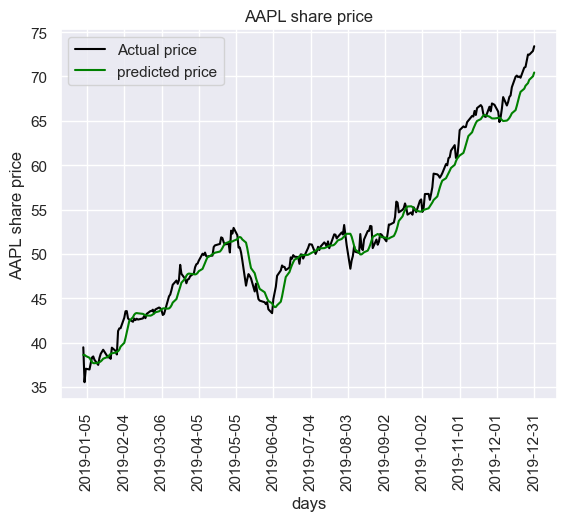

In [93]:
# Plot predicted prices
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation = 90)
x_dates = test_df.index
plt.plot(x_dates, actual_prices, color='black', label=f"Actual price")
plt.plot(x_dates, predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("days")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

## 5d. Evaluating LSTM Model
From our results, we can see that LSTM is able to predict the price with a deviation of 2.60% given N = 50 days worth of data. This represents that for any price that our model predicts, it should vary 2.60% from the actual value. This deviation is too large for short term traders but may be useful for mid-term traders.

![evaluation](images/lstm%20output.png)

In [94]:
# Calculate the error as a percentage
diff = []
for day in range(len(actual_prices)):
    diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

print(sum(diff) / len(diff) * 100, "%")


2.2601911627838396 %


Evaluating our model using the built in evaluation metrics, we get a Mean-Square-Error (MSE) of 2709.42

In [95]:
score = model.evaluate(predicted_prices, actual_prices, verbose=0) 
print("MSE:", score)

MSE: 2709.416259765625


## 5e. Experimenting With Different Values Of N

We repeat what we have done, but with different values of N_PRED_DAYS, namely N = 7 (1 week) and N = 100. To make it easier, we wrap the steps above into a single function.

In [96]:
def lstm_predict(n):
    x_train, y_train = [], []

    for d in range(n, len(scaled_data)):
        # Add previous days values to x_train
        x_train.append(scaled_data[d - n: d, 0])
        # Add current day's value to y_train
        y_train.append(scaled_data[d, 0])    

    # Convert into numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Def LSTM model
    # We change the number of units the model has such that it scales with n. Larger n will result in the model 'remembering' more of the dataset, but risks overfitting
    def LSTM_model():
        model = Sequential()
        
        model.add(LSTM(units = n, return_sequences = True, input_shape = (x_train.shape[1],1)))
        model.add(Dropout(0.2))

        model.add(LSTM(units = n, return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = n))
        model.add(Dropout(0.2))
        
        model.add(Dense(units=1))
        
        return model
    
    # Initialize LSTM model 
    model = LSTM_model()
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Define callbacks, saving only the best model
    checkpointer = ModelCheckpoint(filepath = 'n' + str(n) + '_weights_best.hdf5', 
                                verbose = 2, 
                                save_best_only = True,
                                monitor='loss'
                                )

    # Train model 
    hist = model.fit(x_train, 
            y_train, 
            epochs=35, 
            batch_size = 32,
            callbacks = [checkpointer])
    

    # Prepare model inputs
    model_inputs = close_df[len(train_df) - n:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)


    x_test = []

    for d in range(n, len(model_inputs)):
        x_test.append(model_inputs[d - n: d, 0])

    # Convert to numpy array and reshape to 3D array with appropriate dimensions for LSTM model
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predict the prices 
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Plot predicted prices 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.xticks(rotation = 90)
    x_dates = test_df.index
    plt.plot(x_dates, actual_prices, color='black', label=f"Actual price")
    plt.plot(x_dates, predicted_prices, color= 'green', label=f"predicted price")
    plt.title("AAPL share price")
    plt.xlabel("days")
    plt.ylabel("AAPL share price")
    plt.legend()
    plt.show()


    # Calculate the error as a percentage
    diff = []
    for day in range(len(actual_prices)):
        diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

    print(sum(diff) / len(diff) * 100, "%")

    # Evaluate model using previous evaluation metrics
    score = model.evaluate(predicted_prices, actual_prices, verbose=0) 
    print("MSE:", score)


### 5ei. N_PRED_DAYS = 7


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 7)              252       
                                                                 
 dropout_6 (Dropout)         (None, 7, 7)              0         
                                                                 
 lstm_7 (LSTM)               (None, 7, 7)              420       
                                                                 
 dropout_7 (Dropout)         (None, 7, 7)              0         
                                                                 
 lstm_8 (LSTM)               (None, 7)                 420       
                                                                 
 dropout_8 (Dropout)         (None, 7)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                

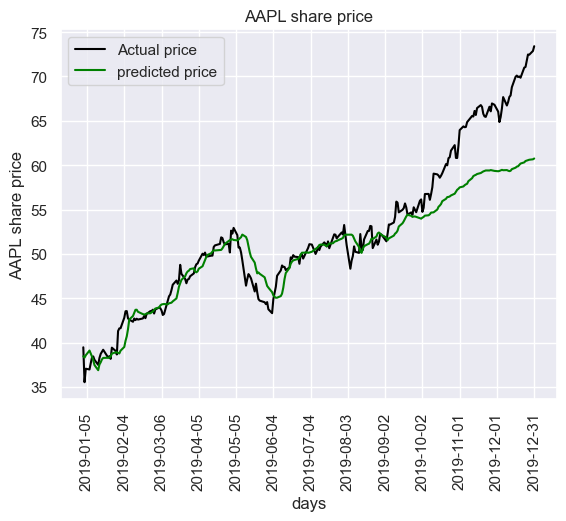

4.206960027289927 %
MSE: 2753.84423828125


In [97]:
lstm_predict(7)

### 5eii. N_PRED_DAYS = 100

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 100)          40800     
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_10 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

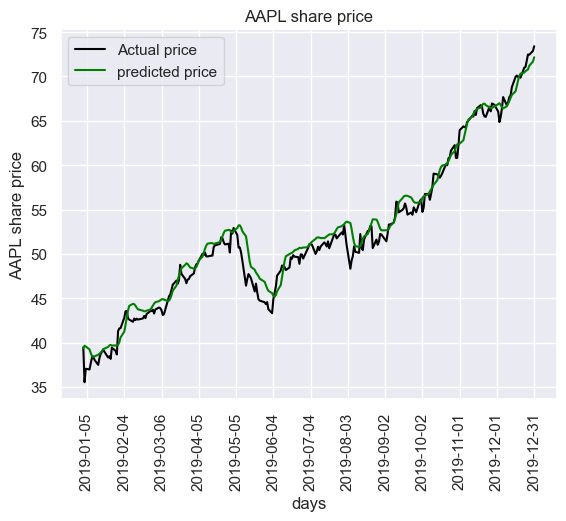

2.0508852807866598 %
MSE: 2569.462890625


In [98]:
lstm_predict(100)

### 5eiii. Observations
By increasing the number of days we base our prediction on, the accuracy improved resulting in a better fit curve and the uncertainty decreasing from 4.21% to 2.05%. The MSE decreased from 2753 to 2569.

However, the increased accuracy comes at a cost of longer training time due to the significant increase in the number of parameters, and the risk of overfitting the model

# 6. Overall Conclusion

When used together, we hope that the 3 models can help investors make better purchasing and selling decisions when it comes to stocks. Ultimately, there are many factors when it comes to stock prices, but we hope that our model was able to cover the 3 most important factors that influence stock prices, which are sentiments, technical indicators, and price patterns.